In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: /home/luky/skola/KalmanNet-main/data/data.mat
Project root added: /home/luky/skola/KalmanNet-main
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import TAN
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
from utils import trainer # Předpokládám, že toto máš

# === 1. ZJEDNODUŠENÝ DATA MANAGER (BEZ NORMALIZACE) ===
class NavigationDataManager:
    def __init__(self, data_dir):
        """
        Jen držák na cestu k datům. Žádná statistika, žádná normalizace.
        """
        self.data_dir = data_dir
        
    def get_dataloader(self, seq_len, split='train', shuffle=True, batch_size=32):
        # Sestavení cesty: ./generated_data/len_100/train.pt
        path = os.path.join(self.data_dir, f'len_{seq_len}', f'{split}.pt')
        
        if not os.path.exists(path):
            raise FileNotFoundError(f"❌ Dataset nenalezen: {path}")
            
        # Načtení tenzorů
        data = torch.load(path)
        x = data['x'] # Stav [Batch, Seq, DimX]
        y = data['y'] # Měření [Batch, Seq, DimY] - RAW DATA
        
        # Vytvoření datasetu
        dataset = TensorDataset(x, y)
        
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# === 2. KONFIGURACE CURRICULA ===
DATA_DIR = './generated_data_synthetic_controlled'

# Inicializace manažera (teď je to jen wrapper pro načítání souborů)
data_manager = NavigationDataManager(DATA_DIR)

# Definice fází (zde řídíš, jak se trénink vyvíjí)
curriculum_schedule = [
    # FÁZE 1: Warm-up (Krátké sekvence)
    {
        'phase_id': 1,
        'seq_len': 10,          
        'epochs': 500,           
        'lr': 1e-3, 
        'batch_size': 256
    },
    
    # FÁZE 2: Stabilizace (Střední délka)
    {
        'phase_id': 2,
        'seq_len': 100, 
        'epochs': 200, 
        'lr': 1e-4,             
        'batch_size': 64
    },
    
    # FÁZE 3: Long-term Reality (Plná délka)
    {
        'phase_id': 3,
        'seq_len': 300,         
        'epochs': 200, 
        'lr': 1e-5,             
        'batch_size': 64       # Menší batch kvůli paměti GPU u dlouhých sekvencí
    }
]

# === 3. NAČÍTÁNÍ DO PAMĚTI (CACHING) ===
print("\n=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===")
datasets_cache = {} 

for phase in curriculum_schedule:
    seq_len = phase['seq_len']
    bs = phase['batch_size']
    
    print(f"📥 Načítám Fázi {phase['phase_id']}: Seq={seq_len} | Batch={bs} ...")
    
    try:
        # Použití DataManageru
        train_loader = data_manager.get_dataloader(seq_len=seq_len, split='train', shuffle=True, batch_size=bs)
        val_loader = data_manager.get_dataloader(seq_len=seq_len, split='val', shuffle=False, batch_size=bs)
        
        # Uložení do cache
        datasets_cache[phase['phase_id']] = (train_loader, val_loader)
        
        # Rychlá kontrola pro jistotu
        x_ex, y_ex = next(iter(train_loader))
        if phase['phase_id'] == 1:
            print(f"   🔎 Ukázka RAW dat (y): {y_ex[0, 0, :].tolist()}") 
            # Měl bys vidět velká čísla (např. 250.0) a malá (0.2), ne ~0.0
        
    except FileNotFoundError as e:
        print(f"   ⚠️ CHYBA: {e}")
        # raise e # Odkomentuj, pokud chceš, aby to spadlo při chybě

print("\n✅ Data připravena. Normalizaci řeší model.")


=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===
📥 Načítám Fázi 1: Seq=10 | Batch=256 ...
   🔎 Ukázka RAW dat (y): [323.7707824707031, -13.519903182983398, -29.721908569335938]
📥 Načítám Fázi 2: Seq=100 | Batch=64 ...
📥 Načítám Fázi 3: Seq=300 | Batch=64 ...

✅ Data připravena. Normalizaci řeší model.


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def gaussian_nll_safe(target, preds, var, min_var=1e-6, max_error_sq=100.0):
    """
    Bezpečná NLL loss funkce.
    """
    safe_var = var + min_var
    error_sq = (preds - target) ** 2
    # Clampujeme velikost chyby v čitateli, aby loss neexplodovala,
    # ale gradient do variance (ve jmenovateli) zůstal zachován.
    error_sq_clamped = torch.clamp(error_sq, max=max_error_sq)
    nll = 0.5 * (torch.log(safe_var) + error_sq_clamped / safe_var)
    return nll.mean()

def train_BayesianKalmanNet_TwoPhase(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period,
    mse_warmup_iters=0,  # <--- NOVÝ PARAMETR: Kolik iterací trénovat jen na MSE
    weight_decay_=1e-5
):
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    # Scheduler (volitelný, zde vypnutý pro jednoduchost)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50)

    best_val_metric = float('inf') # Buď MSE nebo ANEES podle fáze
    best_model_state = None
    best_iter_count = 0
    train_iter_count = 0
    done = False

    print(f"🚀 START Two-Phase Training")
    print(f"    Phase 1: MSE Warmup (0 - {mse_warmup_iters} iters)")
    print(f"    Phase 2: NLL Optimization ({mse_warmup_iters} - {total_train_iter} iters)")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            # Detekce NaN v datech
            if torch.isnan(x_true_batch).any():
                print(f"!!! SKIP BATCH iter {train_iter_count}: NaN found in x_true !!!")
                continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            batch_size, seq_len, _ = x_true_batch.shape
            
            # --- Training Step ---
            optimizer.zero_grad()
            
            all_trajectories_for_ensemble = []
            all_regs_for_ensemble = []

            # 1. Ensemble Forward Pass
            for j in range(J_samples):
                model.reset(batch_size=batch_size, initial_state=x_true_batch[:, 0, :])
                current_trajectory_x_hats = []
                current_trajectory_regs = []
                
                for t in range(1, seq_len):
                    y_t = y_meas_batch[:, t, :]
                    x_filtered_t, reg_t = model.step(y_t)
                    
                    if torch.isnan(x_filtered_t).any():
                        raise ValueError(f"NaN in x_filtered_t at sample {j}, step {t}")
                        
                    current_trajectory_x_hats.append(x_filtered_t)
                    current_trajectory_regs.append(reg_t)
                
                all_trajectories_for_ensemble.append(torch.stack(current_trajectory_x_hats, dim=1))
                all_regs_for_ensemble.append(torch.sum(torch.stack(current_trajectory_regs)))

            # 2. Statistiky Ensemble
            ensemble_trajectories = torch.stack(all_trajectories_for_ensemble, dim=0)
            x_hat_sequence = ensemble_trajectories.mean(dim=0)
            
            # Epistemická variance
            cov_diag_sequence = ensemble_trajectories.var(dim=0) + 1e-9 
            
            # Normalizovaná regularizace (na délku sekvence)
            regularization_loss = torch.stack(all_regs_for_ensemble).mean() / seq_len
            
            target_sequence = x_true_batch[:, 1:, :]
            
            # --- 3. VÝPOČET LOSS (Dvě fáze) ---
            
            # Vždy spočítáme obojí pro logování
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            nll_loss = gaussian_nll_safe(
                target=target_sequence, 
                preds=x_hat_sequence, 
                var=cov_diag_sequence, 
                min_var=1e-5, 
                max_error_sq=100.0
            )
            
            # Rozhodování o optimalizační Loss
            loss_mode = ""
            if train_iter_count < mse_warmup_iters:
                # FÁZE 1: Warmup na MSE
                # Ignorujeme NLL, soustředíme se na trefení trajektorie
                loss = mse_loss + regularization_loss
                loss_mode = "MSE_WARMUP"
            else:
                # FÁZE 2: NLL Optimalizace
                # Minimalizujeme NLL (kalibrace nejistoty + přesnost)
                # MSE zde není přímo v gradientu (je schované v NLL), ale logujeme ho
                loss = nll_loss + regularization_loss
                loss_mode = "NLL_OPTIM"
            
            if torch.isnan(loss): 
                print("Collapse detected (NaN loss)"); done = True; break
            
            loss.backward()

            # --- DIAGNOSTIKA GRADIENTŮ ---
            if train_iter_count % logging_period == 0:
                total_norm = 0.0
                max_grad = 0.0
                nan_grad_detected = False
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2).item()
                        total_norm += param_norm ** 2
                        p_max = p.grad.data.abs().max().item()
                        if p_max > max_grad: max_grad = p_max
                        if torch.isnan(p.grad).any():
                            nan_grad_detected = True
                total_norm = total_norm ** 0.5
                
                if nan_grad_detected:
                     print(f"!!! WARNING: NaN gradient detected at iter {train_iter_count} !!!")

            if clip_grad > 0: 
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
            optimizer.step()
            train_iter_count += 1
            
            # --- LOGGING ---
            if train_iter_count % logging_period == 0:
                with torch.no_grad():
                    # Statistiky variance
                    min_variance = cov_diag_sequence.min().item()
                    max_variance = cov_diag_sequence.max().item()
                    mean_variance = cov_diag_sequence.mean().item()
                    
                    # Dropout pravděpodobnosti
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                    
                    # Chyba v metrech (L1)
                    diff = x_hat_sequence - target_sequence
                    mean_error = diff.abs().mean().item()
                
                print(f"--- Iter [{train_iter_count}/{total_train_iter}] ({loss_mode}) ---")
                print(f"    Total Loss:     {loss.item():.4f}")
                print(f"    MSE (Metric):   {mse_loss.item():.4f}")
                print(f"    NLL (Metric):   {nll_loss.item():.4f}")
                print(f"    Reg Loss:       {regularization_loss.item():.6f}")
                print(f"    Var Stats:      Min={min_variance:.2e}, Max={max_variance:.2e}, Mean={mean_variance:.2e}")
                print(f"    Mean Error L1:  {mean_error:.4f} m")
                print(f"    Grad Norm:      {total_norm:.4f} (Max: {max_grad:.4f})")
                print(f"    Dropout:        p1={p1:.4f}, p2={p2:.4f}")

 # --- VALIDATION (Upravená část) ---
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                print(f"\n--- Validation at iteration {train_iter_count} ---")
                model.eval()
                val_mse_list = []
                
                # Pro ANEES
                all_val_x_true, all_val_x_hat, all_val_P_hat = [], [], []

                with torch.no_grad():
                    for x_true_val, y_meas_val in val_loader:
                        v_bs, v_seq, _ = x_true_val.shape
                        x_true_val = x_true_val.to(device)
                        y_meas_val = y_meas_val.to(device)
                        
                        val_ensemble_trajs = []
                        
                        for j in range(J_samples):
                            model.reset(batch_size=v_bs, initial_state=x_true_val[:, 0, :])
                            v_x_hats = []
                            for t in range(1, v_seq):
                                est, _ = model.step(y_meas_val[:, t, :])
                                v_x_hats.append(est)
                            val_ensemble_trajs.append(torch.stack(v_x_hats, dim=1))
                        
                        val_ens_stack = torch.stack(val_ensemble_trajs, dim=0) # [J, B, T, D]
                        val_mean = val_ens_stack.mean(dim=0)
                        val_var_diag = val_ens_stack.var(dim=0) + 1e-9
                        
                        val_mse_list.append(F.mse_loss(val_mean, x_true_val[:, 1:, :]).item())
                        
                        # --- Příprava dat pro ANEES ---
                        # 1. Stavy (Ground Truth a Odhad)
                        # Přidáme startovní bod (t=0), abychom měli celou sekvenci
                        full_x_hat = torch.cat([x_true_val[:, 0, :].unsqueeze(1), val_mean], dim=1)
                        
                        # 2. Kovariance (P)
                        # Vytvoříme plné matice 4x4 z diagonálního rozptylu
                        val_covs_full = torch.zeros(v_bs, v_seq-1, 4, 4, device=device)
                        # Rychlá vektorizovaná konstrukce diagonály
                        # (Místo cyklu přes batch a čas použijeme diag_embed, pokud to PyTorch verze umí)
                        try:
                            val_covs_full = torch.diag_embed(val_var_diag)
                        except:
                            # Fallback pro starší verze nebo pokud to selže
                            for b in range(v_bs):
                                for t in range(v_seq-1):
                                    val_covs_full[b, t] = torch.diag(val_var_diag[b, t])
                        
                        # P0 (počáteční nejistota - malá)
                        P0 = torch.eye(4, device=device).unsqueeze(0).unsqueeze(0).repeat(v_bs, 1, 1, 1) * 1e-6
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true.append(x_true_val.cpu())
                        all_val_x_hat.append(full_x_hat.cpu())
                        all_val_P_hat.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                
                # --- VÝPOČET ANEES ---
                try:
                    cat_true = torch.cat(all_val_x_true, dim=0)
                    cat_hat = torch.cat(all_val_x_hat, dim=0)
                    cat_P = torch.cat(all_val_P_hat, dim=0)
                    
                    # Voláme vaši funkci (předpokládám, že je v modulu 'trainer' nebo 'utils')
                    # Pokud ji nemáte naimportovanou, musíte ji definovat.
                    # Zde používám 'trainer.calculate_anees_vectorized' z vašeho původního kódu
                    if hasattr(trainer, 'calculate_anees_vectorized'):
                         avg_val_anees = trainer.calculate_anees_vectorized(cat_true, cat_hat, cat_P)
                    else:
                         avg_val_anees = float('nan') # Placeholder
                         
                except Exception as e:
                    print(f"Error calculating ANEES: {e}")
                    avg_val_anees = float('nan')

                print(f"  Avg MSE: {avg_val_mse:.4f} | Avg ANEES: {avg_val_anees:.4f}")
                
                # --- LOGIKA UKLÁDÁNÍ (Smart Saving) ---
                # Ukládáme, pokud se zlepší MSE (priorita 1).
                # Volitelně: Ve fázi NLL by se dalo ukládat, pokud se zlepší ANEES (k ideální 4.0),
                # ale to je riskantní, pokud by MSE vyletělo.
                # Zůstaňme u MSE jako "kotvy kvality".
                
                current_metric = avg_val_mse
                if current_metric < best_val_metric:
                    print(f"  >>> New Best Model! (MSE: {best_val_metric:.4f} -> {current_metric:.4f}) <<<")
                    best_val_metric = current_metric
                    best_iter_count = train_iter_count
                    best_model_state = deepcopy(model.state_dict())
                
                print("-" * 50)
                model.train()

    print("\nTraining completed.")
    if best_model_state:
        print(f"Loading best model from iteration {best_iter_count}")
        model.load_state_dict(best_model_state)
    
    return {"final_model": model}

In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def calculate_anees_vectorized(x_true, x_hat, P_hat, eps=1e-6):
    """
    Robustní výpočet ANEES pomocí Pseudo-Inverze.
    Zvládá i situaci, kdy J_samples < State_Dim (singulární matice).
    """
    # 1. Zploštění (Flattening)
    if x_true.dim() == 3: x_true = x_true.reshape(-1, x_true.shape[-1])
    if x_hat.dim() == 3: x_hat = x_hat.reshape(-1, x_hat.shape[-1])
    if P_hat.dim() == 4: P_hat = P_hat.reshape(-1, P_hat.shape[-2], P_hat.shape[-1])

    # 2. Výpočet chyby
    error = (x_true - x_hat).unsqueeze(-1)  # [N, Dim, 1]
    
    # 3. Pseudo-Inverze matice P
    # pinv je mnohem stabilnější pro Low-Rank matice (když máme málo vzorků)
    # hermitian=True říká, že matice je symetrická (což kovariance je)
    P_inv = torch.linalg.pinv(P_hat, hermitian=True)
    
    # 4. ANEES = error^T * P_inv * error
    # bmm: [N, 1, Dim] @ [N, Dim, Dim] -> [N, 1, Dim]
    #      [N, 1, Dim] @ [N, Dim, 1] -> [N, 1, 1]
    
    temp = torch.bmm(error.transpose(1, 2), P_inv)
    anees_per_sample = torch.bmm(temp, error).squeeze() # [N]
    
    # Ochrana proti numerickým artefaktům (malinká záporná čísla jako -1e-10)
    anees_per_sample = torch.clamp(anees_per_sample, min=0.0)

    return anees_per_sample.mean().item()

def gaussian_nll_safe(target, preds, var, min_var=1e-6, max_error_sq=100.0):
    # 1. Bezpečná variance (epsilon) - správně
    safe_var = var + min_var
    
    # 2. Kvadratická chyba
    error_sq = (preds - target) ** 2
    
    # 3. === OPRAVA ===
    # Clampujeme "velikost chyby", nikoliv "velikost trestu".
    # Tím říkáme: "Pokud je chyba větší než 10m (100m^2), chovej se, jako by byla 10m."
    # Vzorec zůstává: Const / var.
    # Derivace je: -Const / var^2. (To je záporné číslo -> zvyšování var snižuje Loss -> SPRÁVNĚ!)
    error_sq_clamped = torch.clamp(error_sq, max=max_error_sq)
    
    # 4. Výpočet s oříznutou chybou
    nll = 0.5 * (torch.log(safe_var) + error_sq_clamped / safe_var)
    
    return nll.mean()

def train_BayesianKalmanNet_Hybrid(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period,
    warmup_iterations=0, weight_decay_=1e-5,
    lambda_mse=100.0  # <--- NOVÝ PARAMETR: Kotva pro MSE
):
    # torch.autograd.set_detect_anomaly(True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    # Scheduler: Pokud se loss zasekne, snížíme LR (pomáhá stabilizovat konvergenci)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=50
    # )

    best_val_anees = float('inf')
    score_at_best = {"val_nll": 0.0, "val_mse": 0.0}
    best_iter_count = 0
    best_model_state = None
    train_iter_count = 0
    done = False

    print(f"🚀 START Hybrid Training: Loss = NLL + {lambda_mse} * MSE")
    print(f"    Logging period: {logging_period} iterations")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            if torch.isnan(x_true_batch).any():
                print(f"!!! SKIP BATCH iter {train_iter_count}: NaN found in x_true (Ground Truth) !!!")
                continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            # --- Training ---
            optimizer.zero_grad()
            batch_size, seq_len, _ = x_true_batch.shape
            
            all_trajectories_for_ensemble = []
            all_regs_for_ensemble = []

            # 1. Ensemble Forward Pass
            for j in range(J_samples):
                model.reset(batch_size=batch_size, initial_state=x_true_batch[:, 0, :])
                current_trajectory_x_hats = []
                current_trajectory_regs = []
                for t in range(1, seq_len):
                    y_t = y_meas_batch[:, t, :]
                    x_filtered_t, reg_t = model.step(y_t)
                    if torch.isnan(x_filtered_t).any():
                            raise ValueError(f"NaN in x_filtered_t at sample {j}, step {t}")
                    current_trajectory_x_hats.append(x_filtered_t)
                    current_trajectory_regs.append(reg_t)
                all_trajectories_for_ensemble.append(torch.stack(current_trajectory_x_hats, dim=1))
                all_regs_for_ensemble.append(torch.sum(torch.stack(current_trajectory_regs)))

            # 2. Statistiky Ensemble
            ensemble_trajectories = torch.stack(all_trajectories_for_ensemble, dim=0)
            x_hat_sequence = ensemble_trajectories.mean(dim=0)
            
            # Epistemická variance (čistý rozptyl sítě)
            # Přičítáme 1e-9 jen proti dělení nulou, není to "noise floor"
            cov_diag_sequence = ensemble_trajectories.var(dim=0) + 1e-9 
            
            regularization_loss = torch.stack(all_regs_for_ensemble).mean()/seq_len
            target_sequence = x_true_batch[:, 1:, :]
            
            # --- 3. VÝPOČET HYBRIDNÍ LOSS ---
            
            # A) MSE Část (Přesnost)
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            
            # B) NLL Část (Konzistence)
            # 0.5 * (log(var) + (target - pred)^2 / var)
            cov_diag_clamped = torch.clamp(cov_diag_sequence, min=1e-4, max=1e6)
            error_sq = (x_hat_sequence - target_sequence) ** 2
            nll_term = 0.5 * (torch.log(cov_diag_clamped) + error_sq / cov_diag_clamped)
            nll_loss = gaussian_nll_safe(
                target=target_sequence, 
                preds=x_hat_sequence, 
                var=cov_diag_sequence, 
                min_var=1e-5,       # Epsilon pro stabilitu
                max_error_sq=100.0 # Ořezání extrémních chyb (pokud je implementováno)
            )
            mean_var = cov_diag_sequence.mean()
            var_penalty = torch.relu(mean_var - 100.0) * 0.01
            
            # C) Celková Loss (Hybrid)
            # Zde je ta magie: I když NLL chce utéct s variancí, lambda_mse * mse ho drží zpátky
            weighted_mse = lambda_mse * mse_loss
            loss = nll_loss + weighted_mse + regularization_loss * 10.0 + var_penalty
            
            if torch.isnan(loss): 
                print("Collapse detected (NaN loss)"); done = True; break
            
            loss.backward()

            # --- DIAGNOSTIC LOGGING (Gradients) ---
            # Zaznamenáme statistiky gradientů před oříznutím (clippingem)
            if train_iter_count % logging_period == 0:
                total_norm = 0.0
                max_grad = 0.0
                min_grad = float('inf')
                nan_grad_detected = False
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2).item()
                        total_norm += param_norm ** 2
                        p_max = p.grad.data.abs().max().item()
                        p_min = p.grad.data.abs().min().item()
                        if p_max > max_grad: max_grad = p_max
                        if p_min < min_grad: min_grad = p_min
                        if torch.isnan(p.grad).any():
                            nan_grad_detected = True
                total_norm = total_norm ** 0.5
                
                if nan_grad_detected:
                     print(f"!!! WARNING: NaN gradient detected at iter {train_iter_count} !!!")

            if clip_grad > 0: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            train_iter_count += 1
            
            # --- Logging ---
            diff = x_hat_sequence - target_sequence
            mean_error = diff.abs().mean().item()
            min_variance = cov_diag_sequence.min().item()
            max_variance = cov_diag_sequence.max().item()
            mean_variance = cov_diag_sequence.mean().item()

            if train_iter_count % logging_period == 0:
                with torch.no_grad():
                    # Zjistíme dropout pravděpodobnosti (jen pro info)
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                
                print(f"--- Iter [{train_iter_count}/{total_train_iter}] ---")
                print(f"    Total Loss:     {loss.item():.4f}")
                print(f"    MSE (Raw):      {mse_loss.item():.6f}")
                print(f"    MSE (Weighted): {weighted_mse.item():.4f} (lambda={lambda_mse})")
                print(f"    NLL Component:  {nll_loss.item():.4f}")
                print(f"    Reg Loss:       {regularization_loss.item():.6f}")
                print(f"    Variance stats: Min={min_variance:.2e}, Max={max_variance:.2e}, Mean={mean_variance:.2e}")
                print(f"    Mean Error L1:  {mean_error:.4f}")
                print(f"    Grad Norm:      {total_norm:.4f} (Max abs grad: {max_grad:.4f})")
                print(f"    Dropout probs:  p1={p1:.4f}, p2={p2:.4f}")
                
                # Check pro "Variance collapse"
                if mean_variance < 1e-8:
                    print("    !!! WARNING: Variance is extremely low (Collapse risk) !!!")

            # --- Validation step ---
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                # Step scheduleru podle trénovací loss (nebo validace, pokud bys to předělal)
                # scheduler.step(loss)
                
                print(f"\n--- Validation at iteration {train_iter_count} ---")
                model.eval()
                val_mse_list = []
                all_val_x_true_cpu, all_val_x_hat_cpu, all_val_P_hat_cpu = [], [], []

                with torch.no_grad():
                    for x_true_val_batch, y_meas_val_batch in val_loader:
                        val_batch_size, val_seq_len, _ = x_true_val_batch.shape
                        x_true_val_batch = x_true_val_batch.to(device)
                        y_meas_val_batch = y_meas_val_batch.to(device)
                        val_ensemble_trajectories = []
                        for j in range(J_samples):
                            model.reset(batch_size=val_batch_size, initial_state=x_true_val_batch[:, 0, :])
                            val_current_x_hats = []
                            for t in range(1, val_seq_len):
                                y_t_val = y_meas_val_batch[:, t, :]
                                x_filtered_t, _ = model.step(y_t_val)
                                val_current_x_hats.append(x_filtered_t)
                            val_ensemble_trajectories.append(torch.stack(val_current_x_hats, dim=1))
                        
                        # Agregace validace
                        val_ensemble = torch.stack(val_ensemble_trajectories, dim=0)
                        val_preds_seq = val_ensemble.mean(dim=0)
                        
                        val_target_seq = x_true_val_batch[:, 1:, :]
                        val_mse_list.append(F.mse_loss(val_preds_seq, val_target_seq).item())
                        
                        # Příprava pro ANEES
                        initial_state_val = x_true_val_batch[:, 0, :].unsqueeze(1)
                        full_x_hat = torch.cat([initial_state_val, val_preds_seq], dim=1)
                        
                        # Epistemická variance
                        val_covs_diag = val_ensemble.var(dim=0) + 1e-9
                        
                        # Vytvoření diagonálních matic P
                        # (Zjednodušená konstrukce pro ANEES calc)
                        # Pro přesné ANEES bychom měli dělat outer product, 
                        # ale diagonála z var() je dobrá aproximace pro BKN
                        val_covs_full = torch.zeros(val_batch_size, val_seq_len-1, 4, 4, device=device)
                        for b in range(val_batch_size):
                            for t in range(val_seq_len-1):
                                val_covs_full[b, t] = torch.diag(val_covs_diag[b, t])

                        P0 = model.system_model.P0.unsqueeze(0).repeat(val_batch_size, 1, 1).unsqueeze(1)
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true_cpu.append(x_true_val_batch.cpu())
                        all_val_x_hat_cpu.append(full_x_hat.cpu())
                        all_val_P_hat_cpu.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                final_x_true_list = torch.cat(all_val_x_true_cpu, dim=0)
                final_x_hat_list = torch.cat(all_val_x_hat_cpu, dim=0)
                final_P_hat_list = torch.cat(all_val_P_hat_cpu, dim=0)
                
                # Výpočet ANEES
                try:
                    avg_val_anees = calculate_anees_vectorized(final_x_true_list, final_x_hat_list, final_P_hat_list)
                except Exception as e:
                    print(f"  !!! Error calculating ANEES: {e}")
                    avg_val_anees = float('nan')
                
                print(f"  Average MSE: {avg_val_mse:.4f}, Average ANEES: {avg_val_anees:.4f}")
                
                # Ukládání modelu:
                if not np.isnan(avg_val_anees) and avg_val_anees < best_val_anees and avg_val_anees > 0:
                    print(f"  >>> New best VALIDATION ANEES! Saving model. (Old: {best_val_anees:.4f} -> New: {avg_val_anees:.4f}) <<<")
                    best_val_anees = avg_val_anees
                    best_iter_count = train_iter_count
                    score_at_best['val_mse'] = avg_val_mse
                    best_model_state = deepcopy(model.state_dict())
                print("-" * 50)
                model.train()

    print("\nTraining completed.")
    if best_model_state:
        print(f"Loading best model from iteration {best_iter_count} with ANEES {best_val_anees:.4f}")
        model.load_state_dict(best_model_state)
    else:
        print("No best model was saved; returning last state.")

    return {
        "best_val_anees": best_val_anees,
        "best_val_nll": score_at_best['val_nll'],
        "best_val_mse": score_at_best['val_mse'],
        "best_iter": best_iter_count,
        "final_model": model
    }

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

# Předpokládáme existenci helperu (pokud ne, definujte ho jako v minulé odpovědi)
def gaussian_nll_safe(target, preds, var, min_var=1e-6, max_error_sq=100.0):
    safe_var = var + min_var
    error_sq = (preds - target) ** 2
    error_sq_clamped = torch.clamp(error_sq, max=max_error_sq)
    nll = 0.5 * (torch.log(safe_var) + error_sq_clamped / safe_var)
    return nll.mean()

def train_BayesianKalmanNet_TBPTT_TwoPhase(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad=1.0,
    J_samples=5, tbptt_steps=20,
    validation_period=50, logging_period=10,
    mse_warmup_iters=0, # Počet updatů pro MSE fázi
    weight_decay_=1e-5
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    best_val_mse = float('inf')
    best_model_state = None
    train_iter_count = 0 # Počítadlo updatů (gradient steps)
    done = False

    print(f"🚀 START TBPTT Two-Phase Training (Window={tbptt_steps})")
    print(f"    Phase 1: MSE Warmup (0 - {mse_warmup_iters} steps)")
    print(f"    Phase 2: NLL Optimization ({mse_warmup_iters} - {total_train_iter} steps)")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            batch_size, seq_len, dim_x = x_true_batch.shape
            
            # --- SUPER BATCH (Vektorizace) ---
            x_true_super = x_true_batch.repeat_interleave(J_samples, dim=0)
            y_meas_super = y_meas_batch.repeat_interleave(J_samples, dim=0)
            super_batch_size = x_true_super.shape[0]

            # 1. Reset na začátku sekvence
            model.reset(batch_size=super_batch_size, initial_state=x_true_super[:, 0, :])
            
            # Gradienty nulujeme před sekvencí
            optimizer.zero_grad()

            # 2. TBPTT Smyčka přes okna
            for t_start in range(1, seq_len, tbptt_steps):
                if train_iter_count >= total_train_iter: done = True; break

                t_end = min(t_start + tbptt_steps, seq_len)
                current_window_len = t_end - t_start
                if current_window_len <= 0: continue

                # A) Forward pass oknem
                window_x_preds = []
                window_regs = []
                
                for t in range(t_start, t_end):
                    y_t = y_meas_super[:, t, :]
                    x_est, reg = model.step(y_t)
                    window_x_preds.append(x_est)
                    window_regs.append(reg)
                
                # B) Zpracování výsledků okna
                preds_super = torch.stack(window_x_preds, dim=1) # [Batch*J, Window, 4]
                regs_super = torch.stack(window_regs)
                
                # Reshape pro statistiku [Batch, J, Window, 4]
                preds_reshaped = preds_super.view(batch_size, J_samples, current_window_len, dim_x)
                
                x_hat_seq = preds_reshaped.mean(dim=1)
                cov_diag_seq = preds_reshaped.var(dim=1) + 1e-9
                
                target_seq = x_true_batch[:, t_start:t_end, :]

                # C) Výpočet Loss (Two-Phase)
                mse_loss = F.mse_loss(x_hat_seq, target_seq)
                
                # NLL (použijeme bezpečnou funkci)
                nll_loss = gaussian_nll_safe(target_seq, x_hat_seq, cov_diag_seq, max_error_sq=100.0)
                
                # Regularizace (průměr na krok)
                reg_loss = regs_super.mean()
                
                # Rozhodování o Loss
                if train_iter_count < mse_warmup_iters:
                    loss = mse_loss + reg_loss
                    mode = "MSE"
                else:
                    # NLL Fáze (můžeme přidat malou kotvu MSE, např. 0.1, pro stabilitu)
                    loss = nll_loss + reg_loss + (0.1 * mse_loss) 
                    mode = "NLL"

                # D) Backward & Update
                loss.backward()
                
                if clip_grad > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
                
                optimizer.step()
                optimizer.zero_grad() # Důležité: nulujeme po každém kroku TBPTT
                
                # E) Detach Hidden State (Klíčové pro TBPTT)
                model.detach_hidden()
                
                train_iter_count += 1

                # --- Logging ---
                if train_iter_count % logging_period == 0:
                    with torch.no_grad():
                        p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                        p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                        diff = x_hat_seq - target_seq
                        mae = diff.abs().mean().item()
                    
                    print(f"Iter {train_iter_count} ({mode}): Loss {loss.item():.4f} | MSE {mse_loss.item():.2f} | NLL {nll_loss.item():.2f} | MAE {mae:.2f}m")
                    print(f"    Dropout: p1={p1:.3f}, p2={p2:.3f} | VarMean: {cov_diag_seq.mean().item():.1f}")

                # --- Validation (Uvnitř TBPTT smyčky) ---
                if train_iter_count % validation_period == 0:
                    model.eval()
                    val_mse_list = []
                    
                    # Pro ANEES sběr
                    all_val_x_true, all_val_x_hat, all_val_P = [], [], []

                    with torch.no_grad():
                        for x_v, y_v in val_loader:
                            x_v, y_v = x_v.to(device), y_v.to(device)
                            b_v, s_v, _ = x_v.shape
                            
                            # Validace běží Open-Loop na celé sekvenci (bez TBPTT)
                            x_v_sup = x_v.repeat_interleave(J_samples, dim=0)
                            y_v_sup = y_v.repeat_interleave(J_samples, dim=0)
                            
                            model.reset(batch_size=b_v*J_samples, initial_state=x_v_sup[:,0,:])
                            preds_list = []
                            
                            for ti in range(1, s_v):
                                est, _ = model.step(y_v_sup[:, ti, :])
                                preds_list.append(est)
                            
                            preds_stack = torch.stack(preds_list, dim=1).view(b_v, J_samples, s_v-1, 4)
                            val_mean = preds_stack.mean(dim=1)
                            val_var = preds_stack.var(dim=1) + 1e-9
                            
                            val_mse_list.append(F.mse_loss(val_mean, x_v[:, 1:, :]).item())
                            
                            # Data pro ANEES
                            full_hat = torch.cat([x_v[:,0,:].unsqueeze(1), val_mean], dim=1)
                            # Diagonal P construction
                            val_P_full = torch.zeros(b_v, s_v-1, 4, 4, device=device)
                            for b in range(b_v):
                                for t in range(s_v-1):
                                    val_P_full[b,t] = torch.diag(val_var[b,t])
                            P0 = torch.eye(4, device=device).unsqueeze(0).unsqueeze(0).repeat(b_v, 1, 1, 1)*1e-6
                            full_P = torch.cat([P0, val_P_full], dim=1)
                            
                            all_val_x_true.append(x_v.cpu())
                            all_val_x_hat.append(full_hat.cpu())
                            all_val_P.append(full_P.cpu())

                    avg_val_mse = np.mean(val_mse_list)
                    
                    # Calc ANEES
                    try:
                        cat_true = torch.cat(all_val_x_true, dim=0)
                        cat_hat = torch.cat(all_val_x_hat, dim=0)
                        cat_P = torch.cat(all_val_P, dim=0)
                        # Pokud máte funkci importovanou
                        avg_anees = calculate_anees_vectorized(cat_true, cat_hat, cat_P)
                    except:
                        avg_anees = float('nan')

                    print(f"\n--- VALIDATION: MSE {avg_val_mse:.2f} | ANEES {avg_anees:.2f} ---")
                    
                    # Ukládání (podle MSE)
                    if avg_val_mse < best_val_mse:
                        print(f"  >>> New Best Model! (Old: {best_val_mse:.2f} -> New: {avg_val_mse:.2f}) <<<")
                        best_val_mse = avg_val_mse
                        best_model_state = deepcopy(model.state_dict())
                    print("-" * 40)
                    
                    model.train()

    print("TBPTT Training completed.")
    if best_model_state:
        model.load_state_dict(best_model_state)
    return {"final_model": model}

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def gaussian_nll_safe(target, preds, var, min_var=1e-6, max_error_sq=100.0):
    safe_var = var + min_var
    error_sq = (preds - target) ** 2
    error_sq_clamped = torch.clamp(error_sq, max=max_error_sq)
    nll = 0.5 * (torch.log(safe_var) + error_sq_clamped / safe_var)
    return nll.mean()
def calculate_anees_vectorized(x_true, x_hat, P_hat, eps=1e-6):
    """
    Robustní výpočet ANEES pomocí Pseudo-Inverze.
    Zvládá i situaci, kdy J_samples < State_Dim (singulární matice).
    """
    # 1. Zploštění (Flattening)
    if x_true.dim() == 3: x_true = x_true.reshape(-1, x_true.shape[-1])
    if x_hat.dim() == 3: x_hat = x_hat.reshape(-1, x_hat.shape[-1])
    if P_hat.dim() == 4: P_hat = P_hat.reshape(-1, P_hat.shape[-2], P_hat.shape[-1])

    # 2. Výpočet chyby
    error = (x_true - x_hat).unsqueeze(-1)  # [N, Dim, 1]
    
    # 3. Pseudo-Inverze matice P
    # pinv je mnohem stabilnější pro Low-Rank matice (když máme málo vzorků)
    # hermitian=True říká, že matice je symetrická (což kovariance je)
    P_inv = torch.linalg.pinv(P_hat, hermitian=True)
    
    # 4. ANEES = error^T * P_inv * error
    # bmm: [N, 1, Dim] @ [N, Dim, Dim] -> [N, 1, Dim]
    #      [N, 1, Dim] @ [N, Dim, 1] -> [N, 1, 1]
    
    temp = torch.bmm(error.transpose(1, 2), P_inv)
    anees_per_sample = torch.bmm(temp, error).squeeze() # [N]
    
    # Ochrana proti numerickým artefaktům (malinká záporná čísla jako -1e-10)
    anees_per_sample = torch.clamp(anees_per_sample, min=0.0)

    return anees_per_sample.mean().item()

def train_BayesianKalmanNet_TBPTT_Windowed(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad=1.0,
    J_samples=5, 
    tbptt_k=5,   
    tbptt_w=20,  
    validation_period=50, logging_period=10,
    mse_warmup_iters=0, 
    weight_decay_=1e-5,
    lambda_mse=100.0,
    calibration_parameter=10.0
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    best_val_score = float('inf')
    best_model_state = None
    train_iter_count = 0 
    done = False

    if not hasattr(model, 'detach_hidden'):
         raise AttributeError("Modelu chybí metoda 'detach_hidden()'.")

    print(f"🚀 START TBPTT Windowed Training (k={tbptt_k}, w={tbptt_w})")
    print(f"    Phase 1: MSE Warmup (0 - {mse_warmup_iters} updates)")
    print(f"    Phase 2: NLL Optimization (> {mse_warmup_iters} updates)")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            batch_size, seq_len, dim_x = x_true_batch.shape
            
            x_true_super = x_true_batch.repeat_interleave(J_samples, dim=0)
            y_meas_super = y_meas_batch.repeat_interleave(J_samples, dim=0)
            super_batch_size = x_true_super.shape[0]

            # 1. Hard Reset na začátku sekvence
            # Vyčistíme vše, aby reset vytvořil správné velikosti
            if hasattr(model, 'h_prev'): model.h_prev = None
            if hasattr(model, 'x_filtered_t_minus_1'): model.x_filtered_t_minus_1 = None
            if hasattr(model, 'x_filtered_t_minus_2'): model.x_filtered_t_minus_2 = None
            
            model.reset(batch_size=super_batch_size, initial_state=x_true_super[:, 0, :])
            
            # 2. TBPTT Loop
            for t_start in range(1, seq_len, tbptt_w):
                if train_iter_count >= total_train_iter: done = True; break

                t_end = min(t_start + tbptt_w, seq_len)
                current_window_len = t_end - t_start
                if current_window_len <= 0: continue

                optimizer.zero_grad()
                window_x_preds = []
                window_regs = []

                # A) Forward pass
                for t in range(t_start, t_end):
                    y_t = y_meas_super[:, t, :]
                    x_est, reg = model.step(y_t)
                    window_x_preds.append(x_est)
                    window_regs.append(reg)
                    
                    if (t - t_start + 1) % tbptt_k == 0:
                        model.detach_hidden()

                model.detach_hidden()

                # B) Loss Calculation
                preds_super = torch.stack(window_x_preds, dim=1)
                regs_super = torch.stack(window_regs)
                preds_reshaped = preds_super.view(batch_size, J_samples, current_window_len, dim_x)
                
                x_hat_seq = preds_reshaped.mean(dim=1)
                cov_diag_seq = preds_reshaped.var(dim=1) + 1e-9
                target_seq = x_true_batch[:, t_start:t_end, :]

                mse_loss = F.mse_loss(x_hat_seq, target_seq)
                nll_loss = gaussian_nll_safe(target_seq, x_hat_seq, cov_diag_seq, max_error_sq=100.0)
                reg_loss = regs_super.mean()

                if train_iter_count < mse_warmup_iters:
                    loss = mse_loss + reg_loss
                    mode = "MSE_WARMUP"
                else:
                    loss = nll_loss + reg_loss + (lambda_mse * mse_loss)
                    mode = "NLL_OPTIM"

                # C) Update
                loss.backward()
                if clip_grad > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
                optimizer.step()
                optimizer.zero_grad() 
                model.detach_hidden()
                
                train_iter_count += 1
                
                if train_iter_count % logging_period == 0:
                    with torch.no_grad():
                        diff = x_hat_seq - target_seq
                        mae = diff.abs().mean().item()
                        
                        # Získání hodnot dropoutu (sigmoida z logitů)
                        p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                        p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                        
                    print(f"Iter {train_iter_count} ({mode}): "
                          f"Loss {loss.item():.4f} | "
                          f"MSE {mse_loss.item():.2f} | "
                          f"NLL {nll_loss.item():.2f} | "
                          f"Reg {reg_loss.item():.5f} | " # Regularizační loss
                          f"MAE {mae:.2f}m | "
                          f"p1={p1:.3f}, p2={p2:.3f}")    # Dropout pravděpodobnosti
                if train_iter_count % logging_period == 0:
                    with torch.no_grad():
                        diff = x_hat_seq - target_seq
                        mae = diff.abs().mean().item()
                    print(f"Iter {train_iter_count} ({mode}): Loss {loss.item():.4f} | MSE {mse_loss.item():.2f} | NLL {nll_loss.item():.2f} | MAE {mae:.2f}m")

                # --- VALIDATION WITH FULL STATE RESTORE (FIXED) ---
                if train_iter_count % validation_period == 0:
                    # 1. ULOŽIT KOMPLETNÍ STAV TRÉNINKU
                    # Musíme uložit úplně všechno, co se mění v čase t
                    train_state = {}
                    
                    if model.h_prev is not None:
                        train_state['h_prev'] = model.h_prev.detach().clone()
                    
                    train_state['x_filt_1'] = model.x_filtered_t_minus_1.detach().clone()
                    train_state['x_pred_1'] = model.x_pred_t_minus_1.detach().clone()
                    
                    # !!! ZDE BYLA CHYBA: Musíme uložit i t-2 a y_t-1 !!!
                    if hasattr(model, 'x_filtered_t_minus_2') and model.x_filtered_t_minus_2 is not None:
                        train_state['x_filt_2'] = model.x_filtered_t_minus_2.detach().clone()
                    
                    if hasattr(model, 'y_t_minus_1') and model.y_t_minus_1 is not None:
                        train_state['y_1'] = model.y_t_minus_1.detach().clone()
                    
                    if hasattr(model, 'P_t_minus_1') and model.P_t_minus_1 is not None:
                        train_state['P'] = model.P_t_minus_1.detach().clone()

                    # 2. Spustit Validaci
                    model.eval()
                    val_mse_list = []
                    all_val_x_true, all_val_x_hat, all_val_P = [], [], []

                    with torch.no_grad():
                        for x_v, y_v in val_loader:
                            x_v, y_v = x_v.to(device), y_v.to(device)
                            b_v, s_v, _ = x_v.shape
                            x_v_sup = x_v.repeat_interleave(J_samples, dim=0)
                            y_v_sup = y_v.repeat_interleave(J_samples, dim=0)
                            
                            # Hard reset pro validaci (smaže interní proměnné)
                            if hasattr(model, 'h_prev'): model.h_prev = None
                            model.reset(batch_size=b_v*J_samples, initial_state=x_v_sup[:,0,:])
                            
                            preds_list = []
                            for ti in range(1, s_v):
                                est, _ = model.step(y_v_sup[:, ti, :])
                                preds_list.append(est)
                            
                            preds_stack = torch.stack(preds_list, dim=1).view(b_v, J_samples, s_v-1, 4)
                            val_mean = preds_stack.mean(dim=1)
                            val_var = preds_stack.var(dim=1) + 1e-9
                            target_v = x_v[:, 1:, :] 
                            
                            val_mse_list.append(F.mse_loss(val_mean, target_v).item())
                            
                            # Ukládáme jen srovnatelné tensory (bez t=0)
                            all_val_x_true.append(target_v.cpu()) # Zde byla chyba (bylo x_v)
                            all_val_x_hat.append(val_mean.cpu())
                            
                            # P matice musí odpovídat val_mean (tedy bez t=0)
                            val_P_full = torch.zeros(b_v, s_v-1, 4, 4, device=device)
                            for i in range(4): val_P_full[:, :, i, i] = val_var[:, :, i]
                            # P0 nepřidáváme, protože nemáme odhad pro t=0
                            all_val_P.append(val_P_full.cpu())

                    avg_val_mse = np.mean(val_mse_list)
                    
                    try:
                        cat_true = torch.cat(all_val_x_true, dim=0)
                        cat_hat = torch.cat(all_val_x_hat, dim=0)
                        cat_P = torch.cat(all_val_P, dim=0)
                        # Nyní mají tensory shodnou délku, takže reshape projde
                        avg_anees = calculate_anees_vectorized(cat_true, cat_hat, cat_P)
                    except Exception as e:
                        # Vypíšeme chybu, ať víme, co se děje, místo tichého nan
                        print(f"ANEES Error: {e}")
                        avg_anees = float('nan')

                    anees_penalty = abs(avg_anees - 4.0) if not np.isnan(avg_anees) else 100.0
                    
                    # Score = MSE + 10 * ANEES_deviation
                    # Pokud je ANEES 4.0, score = MSE. 
                    # Pokud je ANEES 20.0, score = MSE + 160 (výrazné zhoršení).
                    hybrid_score = avg_val_mse + (calibration_parameter * anees_penalty)

                    print(f"\n--- VALIDATION: MSE {avg_val_mse:.2f} | ANEES {avg_anees:.2f} | Score {hybrid_score:.2f} ---")
                    
                    # Ukládáme, pokud je hybridní skóre lepší (menší)
                    if hybrid_score < best_val_score:
                        print(f"  >>> New Best Model! (Old Score: {best_val_score:.2f} -> New: {hybrid_score:.2f}) <<<")
                        best_val_score = hybrid_score
                        best_model_state = deepcopy(model.state_dict())
                    print("-" * 40)
                    
                    # 3. OBNOVIT KOMPLETNÍ STAV TRÉNINKU
                    model.train()
                    if 'h_prev' in train_state: model.h_prev = train_state['h_prev']
                    model.x_filtered_t_minus_1 = train_state['x_filt_1']
                    model.x_pred_t_minus_1 = train_state['x_pred_1']
                    
                    if 'x_filt_2' in train_state: model.x_filtered_t_minus_2 = train_state['x_filt_2']
                    if 'y_1' in train_state: model.y_t_minus_1 = train_state['y_1']
                    if 'P' in train_state: model.P_t_minus_1 = train_state['P']

    print("Training completed.")
    if best_model_state:
        model.load_state_dict(best_model_state)
    return {"final_model": model}

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def gaussian_nll_safe(target, preds, var, min_var=1e-6, max_error_sq=100.0):
    safe_var = var + min_var
    error_sq = (preds - target) ** 2
    error_sq_clamped = torch.clamp(error_sq, max=max_error_sq)
    nll = 0.5 * (torch.log(safe_var) + error_sq_clamped / safe_var)
    return nll.mean()

def calculate_anees_internal(x_true, x_hat, P_hat):
    if P_hat.dim() == x_hat.dim(): # Diagonální variance
        error_sq = (x_true - x_hat) ** 2
        nees_per_sample = (error_sq / (P_hat + 1e-9)).sum(dim=-1)
        return nees_per_sample.mean().item()
    return float('nan')

def train_BayesianKalmanNet_TBPTT_Windowed(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad=1.0,
    J_samples=5, 
    tbptt_k=5,   
    tbptt_w=20,  
    validation_period=50, logging_period=10,
    mse_warmup_iters=0, 
    weight_decay_=1e-5,
    lambda_mse=1.0,
    calibration_parameter=10.0
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    best_val_score = float('inf')
    best_model_state = None
    train_iter_count = 0 
    done = False

    if not hasattr(model, 'detach_hidden'):
         raise AttributeError("Modelu chybí metoda 'detach_hidden()'.")

    print(f"🚀 START TBPTT Windowed Training (k={tbptt_k}, w={tbptt_w})")
    print(f"    Phase 1: MSE Focused (Soft NLL) (0 - {mse_warmup_iters} updates)")
    print(f"    Phase 2: NLL Optimization (> {mse_warmup_iters} updates)")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            batch_size, seq_len, dim_x = x_true_batch.shape
            
            x_true_super = x_true_batch.repeat_interleave(J_samples, dim=0)
            y_meas_super = y_meas_batch.repeat_interleave(J_samples, dim=0)
            super_batch_size = x_true_super.shape[0]

            # 1. Hard Reset
            if hasattr(model, 'h_prev'): model.h_prev = None
            if hasattr(model, 'x_filtered_t_minus_1'): model.x_filtered_t_minus_1 = None
            if hasattr(model, 'x_filtered_t_minus_2'): model.x_filtered_t_minus_2 = None
            model.reset(batch_size=super_batch_size, initial_state=x_true_super[:, 0, :])
            
            # 2. TBPTT Loop
            for t_start in range(1, seq_len, tbptt_w):
                if train_iter_count >= total_train_iter: done = True; break

                t_end = min(t_start + tbptt_w, seq_len)
                if t_end - t_start <= 0: continue

                # Teacher Forcing (20%)
                use_teacher_forcing = (np.random.rand() < 0.2) 
                if use_teacher_forcing and t_start > 1:
                    gt_state_prev = x_true_super[:, t_start-1, :]
                    model.x_filtered_t_minus_1 = gt_state_prev.detach().clone()
                    model.x_pred_t_minus_1 = gt_state_prev.detach().clone()
                    model.detach_hidden() 
                else:
                    model.detach_hidden()

                optimizer.zero_grad()
                window_x_preds = []
                window_regs = []

                # A) Forward pass
                for t in range(t_start, t_end):
                    y_t = y_meas_super[:, t, :]
                    x_est, reg = model.step(y_t)
                    window_x_preds.append(x_est)
                    window_regs.append(reg)
                    
                    if (t - t_start + 1) % tbptt_k == 0:
                        model.detach_hidden()

                model.detach_hidden()

                # B) Loss Calculation
                preds_super = torch.stack(window_x_preds, dim=1)
                regs_super = torch.stack(window_regs)
                preds_reshaped = preds_super.view(batch_size, J_samples, -1, dim_x)
                
                x_hat_seq = preds_reshaped.mean(dim=1)
                cov_diag_seq = preds_reshaped.var(dim=1) + 1e-9
                target_seq = x_true_batch[:, t_start:t_end, :]

                mse_loss = F.mse_loss(x_hat_seq, target_seq)
                nll_loss = gaussian_nll_safe(target_seq, x_hat_seq, cov_diag_seq, max_error_sq=100.0)
                reg_loss = regs_super.mean()

                # Soft Warmup Strategy
                if train_iter_count < mse_warmup_iters:
                    loss = (1.0 * mse_loss) + nll_loss + reg_loss
                    mode = "MSE_WARMUP"
                else:
                    loss = nll_loss + reg_loss + (lambda_mse * mse_loss)
                    mode = "NLL_OPTIM"

                # C) Update
                loss.backward()
                if clip_grad > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
                optimizer.step()
                optimizer.zero_grad() 
                model.detach_hidden()
                
                train_iter_count += 1

                # --- LOGGING (S PŘIDANOU METRIKOU SIGMA) ---
                if train_iter_count % logging_period == 0:
                    with torch.no_grad():
                        mae = (x_hat_seq - target_seq).abs().mean().item()
                        # Průměrná směrodatná odchylka v metrech (sqrt(variance))
                        avg_sigma = cov_diag_seq.mean().sqrt().item()
                        
                        p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                        p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                        
                    print(f"Iter {train_iter_count} ({mode}): "
                          f"Loss {loss.item():.2f} | "
                          f"MSE {mse_loss.item():.2f} | "
                          f"NLL {nll_loss.item():.2f} | "
                          f"Sigma {avg_sigma:.2f}m | " # <--- ZDE VIDÍTE NEURČITOST
                          f"MAE {mae:.2f}m | "
                          f"p1={p1:.2f}, p2={p2:.2f}")

                # --- VALIDATION ---
                if train_iter_count % validation_period == 0:
                    train_state = {}
                    if model.h_prev is not None: train_state['h_prev'] = model.h_prev.detach().clone()
                    train_state['x_filt_1'] = model.x_filtered_t_minus_1.detach().clone()
                    train_state['x_pred_1'] = model.x_pred_t_minus_1.detach().clone()
                    if hasattr(model, 'x_filtered_t_minus_2') and model.x_filtered_t_minus_2 is not None:
                        train_state['x_filt_2'] = model.x_filtered_t_minus_2.detach().clone()
                    if hasattr(model, 'y_t_minus_1') and model.y_t_minus_1 is not None:
                        train_state['y_1'] = model.y_t_minus_1.detach().clone()
                    if hasattr(model, 'P_t_minus_1') and model.P_t_minus_1 is not None:
                        train_state['P'] = model.P_t_minus_1.detach().clone()

                    model.eval()
                    val_mse_list = []
                    all_val_x_true, all_val_x_hat, all_val_P = [], [], []
                    
                    # Pro výpočet průměrné sigmy ve validaci
                    val_sigma_sum = 0.0
                    val_batch_count = 0

                    with torch.no_grad():
                        for x_v, y_v in val_loader:
                            x_v, y_v = x_v.to(device), y_v.to(device)
                            b_v, s_v, _ = x_v.shape
                            x_v_sup = x_v.repeat_interleave(J_samples, dim=0)
                            y_v_sup = y_v.repeat_interleave(J_samples, dim=0)
                            
                            if hasattr(model, 'h_prev'): model.h_prev = None
                            model.reset(batch_size=b_v*J_samples, initial_state=x_v_sup[:,0,:])
                            
                            preds_list = []
                            for ti in range(1, s_v):
                                est, _ = model.step(y_v_sup[:, ti, :])
                                preds_list.append(est)
                            
                            preds_stack = torch.stack(preds_list, dim=1).view(b_v, J_samples, s_v-1, 4)
                            val_mean = preds_stack.mean(dim=1)
                            val_var = preds_stack.var(dim=1) + 1e-9
                            target_v = x_v[:, 1:, :] 
                            
                            val_mse_list.append(F.mse_loss(val_mean, target_v).item())
                            
                            # Logging sigma stats
                            val_sigma_sum += val_var.mean().sqrt().item()
                            val_batch_count += 1
                            
                            all_val_x_true.append(target_v)
                            all_val_x_hat.append(val_mean)
                            all_val_P.append(val_var)

                    avg_val_mse = np.mean(val_mse_list)
                    avg_val_sigma = val_sigma_sum / max(1, val_batch_count)
                    
                    try:
                        cat_true = torch.cat(all_val_x_true, dim=0)
                        cat_hat = torch.cat(all_val_x_hat, dim=0)
                        cat_P = torch.cat(all_val_P, dim=0)
                        avg_anees = calculate_anees_internal(cat_true, cat_hat, cat_P)
                    except Exception as e:
                        print(f"ANEES Error: {e}")
                        avg_anees = 100.0

                    anees_penalty = abs(avg_anees - 4.0)
                    hybrid_score = avg_val_mse + (calibration_parameter * anees_penalty)

                    print(f"--- VALIDATION: MSE {avg_val_mse:.2f} | Sigma {avg_val_sigma:.2f}m | ANEES {avg_anees:.2f} | Score {hybrid_score:.2f} ---")
                    
                    if hybrid_score < best_val_score:
                        print(f"  >>> New Best Model! (Score: {best_val_score:.2f} -> {hybrid_score:.2f}) <<<")
                        best_val_score = hybrid_score
                        best_model_state = deepcopy(model.state_dict())
                    print("-" * 40)
                    
                    # 3. Restore State
                    model.train()
                    if 'h_prev' in train_state: model.h_prev = train_state['h_prev']
                    model.x_filtered_t_minus_1 = train_state['x_filt_1']
                    model.x_pred_t_minus_1 = train_state['x_pred_1']
                    if 'x_filt_2' in train_state: model.x_filtered_t_minus_2 = train_state['x_filt_2']
                    if 'y_1' in train_state: model.y_t_minus_1 = train_state['y_1']
                    if 'P' in train_state: model.P_t_minus_1 = train_state['P']

    print("Training completed.")
    if best_model_state:
        model.load_state_dict(best_model_state)
    return {"final_model": model}

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
import sys

# Ensure utils is importable if needed
# import utils.utils as utils 

def gaussian_nll_safe(target, preds, var, min_var=1e-6, max_error_sq=100.0):
    """
    Bezpečná NLL loss funkce.
    """
    safe_var = var + min_var
    error_sq = (preds - target) ** 2
    # Clampujeme velikost chyby v čitateli, aby loss neexplodovala
    error_sq_clamped = torch.clamp(error_sq, max=max_error_sq)
    nll = 0.5 * (torch.log(safe_var) + error_sq_clamped / safe_var)
    return nll.mean()

def train_BayesianKalmanNet_TwoPhase(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period,
    mse_warmup_iters=0,
    calibration_parameter=0.0, # <--- NOVÝ PARAMETR: Váha pro ANEES v hybridním skóre
    weight_decay_=1e-5
):
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    # Tracking
    best_hybrid_score = float('inf') # Hlavní metrika pro ukládání
    best_model_state = None
    best_iter_count = 0
    
    # Výsledky pro return
    best_val_mse = float('inf')
    best_val_anees = float('inf')
    best_val_nll = float('inf')

    train_iter_count = 0
    done = False

    print(f"🚀 START Two-Phase Training")
    print(f"    Phase 1: MSE Warmup (0 - {mse_warmup_iters} iters)")
    print(f"    Phase 2: NLL Optimization ({mse_warmup_iters} - {total_train_iter} iters)")
    print(f"    Saving Strategy: Hybrid Score = MSE + ({calibration_parameter} * |ANEES - 4.0|)")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            # Detekce NaN v datech
            if torch.isnan(x_true_batch).any():
                print(f"!!! SKIP BATCH iter {train_iter_count}: NaN found in x_true !!!")
                continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            batch_size, seq_len, _ = x_true_batch.shape
            
            # --- Training Step ---
            optimizer.zero_grad()
            
            all_trajectories_for_ensemble = []
            all_regs_for_ensemble = []

            # 1. Ensemble Forward Pass
            for j in range(J_samples):
                model.reset(batch_size=batch_size, initial_state=x_true_batch[:, 0, :])
                current_trajectory_x_hats = []
                current_trajectory_regs = []
                
                for t in range(1, seq_len):
                    y_t = y_meas_batch[:, t, :]
                    x_filtered_t, reg_t = model.step(y_t)
                    
                    if torch.isnan(x_filtered_t).any():
                        # Fail-safe pro numerickou nestabilitu
                        print(f"NaN detected in forward pass at iter {train_iter_count}")
                        loss = torch.tensor(float('nan'), requires_grad=True) # Dummy NaN loss
                        break 
                        
                    current_trajectory_x_hats.append(x_filtered_t)
                    current_trajectory_regs.append(reg_t)
                
                if len(current_trajectory_x_hats) != (seq_len - 1): break # Pokud nastal break v inner loop

                all_trajectories_for_ensemble.append(torch.stack(current_trajectory_x_hats, dim=1))
                all_regs_for_ensemble.append(torch.sum(torch.stack(current_trajectory_regs)))

            if len(all_trajectories_for_ensemble) < J_samples:
                 # Pokud nějaký sample selhal, přeskočíme update
                 optimizer.zero_grad()
                 continue

            # 2. Statistiky Ensemble
            ensemble_trajectories = torch.stack(all_trajectories_for_ensemble, dim=0)
            x_hat_sequence = ensemble_trajectories.mean(dim=0)
            
            # Epistemická variance
            cov_diag_sequence = ensemble_trajectories.var(dim=0) + 1e-9 
            
            # Regularizace
            regularization_loss = torch.stack(all_regs_for_ensemble).mean() / seq_len
            
            target_sequence = x_true_batch[:, 1:, :]
            
            # --- 3. VÝPOČET LOSS ---
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            nll_loss = gaussian_nll_safe(
                target=target_sequence, 
                preds=x_hat_sequence, 
                var=cov_diag_sequence
            )
            
            # Přepínání fází
            mode = ""
            if train_iter_count < mse_warmup_iters:
                loss = mse_loss + regularization_loss
                mode = "Warmup"
            else:
                loss = nll_loss + regularization_loss
                mode = "Optim"
            
            if torch.isnan(loss): 
                print("Collapse detected (NaN loss)"); done = True; break
            
            loss.backward()

            if clip_grad > 0: 
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            
            optimizer.step()
            train_iter_count += 1
            
            # --- LOGGING ---
            if train_iter_count % logging_period == 0:
                with torch.no_grad():
                    # Výpočet průměrné směrodatné odchylky v metrech (Sigma)
                    # cov_diag_sequence je variance [m^2], odmocníme pro metry
                    avg_sigma = torch.sqrt(cov_diag_sequence).mean().item()
                    
                    # MAE (Mean Absolute Error) v metrech
                    mae = (x_hat_sequence - target_sequence).abs().mean().item()
                    
                    # Dropout pravděpodobnosti
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                
                # Formátovaný výpis dle požadavku
                print(f"Iter {train_iter_count} ({mode}): "
                      f"Loss {loss.item():.2f} | "
                      f"MSE {mse_loss.item():.2f} | "
                      f"NLL {nll_loss.item():.2f} | "
                      f"Sigma {avg_sigma:.2f}m | " 
                      f"MAE {mae:.2f}m | "
                      f"p1={p1:.2f}, p2={p2:.2f}")

            # --- VALIDATION ---
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                print(f"\n--- Validation at iteration {train_iter_count} ---")
                model.eval()
                val_mse_list = []
                val_nll_list = []
                
                all_val_x_true, all_val_x_hat, all_val_P_hat = [], [], []

                with torch.no_grad():
                    for x_true_val, y_meas_val in val_loader:
                        v_bs, v_seq, _ = x_true_val.shape
                        x_true_val = x_true_val.to(device)
                        y_meas_val = y_meas_val.to(device)
                        
                        val_ensemble_trajs = []
                        
                        for j in range(J_samples):
                            model.reset(batch_size=v_bs, initial_state=x_true_val[:, 0, :])
                            v_x_hats = []
                            for t in range(1, v_seq):
                                est, _ = model.step(y_meas_val[:, t, :])
                                v_x_hats.append(est)
                            val_ensemble_trajs.append(torch.stack(v_x_hats, dim=1))
                        
                        val_ens_stack = torch.stack(val_ensemble_trajs, dim=0)
                        val_mean = val_ens_stack.mean(dim=0)
                        val_var_diag = val_ens_stack.var(dim=0) + 1e-9
                        
                        # Metriky
                        val_mse_list.append(F.mse_loss(val_mean, x_true_val[:, 1:, :]).item())
                        val_nll_list.append(gaussian_nll_safe(x_true_val[:, 1:, :], val_mean, val_var_diag).item())
                        
                        # Data pro ANEES
                        full_x_hat = torch.cat([x_true_val[:, 0, :].unsqueeze(1), val_mean], dim=1)
                        
                        # Konstrukce plné kovarianční matice P
                        # Použijeme diag_embed pro efektivitu, fallback na cyklus
                        try:
                            val_covs_full = torch.diag_embed(val_var_diag)
                        except:
                            val_covs_full = torch.zeros(v_bs, v_seq-1, 4, 4, device=device)
                            for b in range(v_bs):
                                for t in range(v_seq-1):
                                    val_covs_full[b, t] = torch.diag(val_var_diag[b, t])
                        
                        P0 = torch.eye(4, device=device).unsqueeze(0).unsqueeze(0).repeat(v_bs, 1, 1, 1) * 1e-6
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true.append(x_true_val.cpu())
                        all_val_x_hat.append(full_x_hat.cpu())
                        all_val_P_hat.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                avg_val_nll = np.mean(val_nll_list)
                
                # Výpočet ANEES
                try:
                    # Zde předpokládám, že funkce calculate_anees_vectorized je dostupná
                    # buď v 'trainer' nebo importovaná z 'utils'
                    from utils import trainer as tr_utils # Lokální import pro jistotu
                    avg_val_anees = tr_utils.calculate_anees_vectorized(
                        torch.cat(all_val_x_true, dim=0), 
                        torch.cat(all_val_x_hat, dim=0), 
                        torch.cat(all_val_P_hat, dim=0)
                    )
                except:
                    # Fallback pokud import selže, nastavíme na 4.0 (ideál) aby nezkazilo skóre
                    # nebo NaN pro info
                    avg_val_anees = 100.0 # Velké číslo aby to bylo vidět
                    # print("Warning: ANEES calculation failed.")

                # --- HYBRID SCORE CALCULATION ---
                anees_diff = abs(avg_val_anees - 4.0)
                hybrid_score = avg_val_mse + (calibration_parameter * anees_diff)

                print(f"  > Val MSE: {avg_val_mse:.4f} | Val ANEES: {avg_val_anees:.4f} | Hybrid Score: {hybrid_score:.4f}")
                
                # Ukládání podle Hybrid Score
                if hybrid_score < best_hybrid_score:
                    print(f"  >>> ⭐ New Best Model! (Score: {best_hybrid_score:.4f} -> {hybrid_score:.4f})")
                    best_hybrid_score = hybrid_score
                    best_iter_count = train_iter_count
                    best_model_state = deepcopy(model.state_dict())
                    
                    # Uložíme si metriky tohoto nejlepšího modelu
                    best_val_mse = avg_val_mse
                    best_val_anees = avg_val_anees
                    best_val_nll = avg_val_nll
                
                print("-" * 60)
                model.train()

    print("\nTraining completed.")
    if best_model_state:
        print(f"Loading best model from iteration {best_iter_count} (Score: {best_hybrid_score:.4f})")
        model.load_state_dict(best_model_state)
    
    # Vracíme slovník výsledků pro uložení
    return {
        "final_model": model,
        "best_iter": best_iter_count,
        "best_val_mse": best_val_mse,
        "best_val_anees": best_val_anees,
        "best_val_nll": best_val_nll
    }

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy
import torch

def calculate_anees_vectorized(x_true: torch.Tensor, x_hat: torch.Tensor, P_hat: torch.Tensor) -> float:
    """
    Vektorizovaný výpočet ANEES (Average Normalized Estimation Error Squared)
    pro plné kovarianční matice.
    
    Parametry:
    x_true: Tensor tvaru (Batch, SeqLen, StateDim) - skutečné stavy (Ground Truth)
    x_hat: Tensor tvaru (Batch, SeqLen, StateDim) - odhadnuté stavy filtrem
    P_hat: Tensor tvaru (Batch, SeqLen, StateDim, StateDim) - odhadnuté plné kovarianční matice
    
    Návratová hodnota:
    Skalár - průměrná hodnota ANEES (ideálně by se měla blížit StateDim, pro TAN to je 4.0)
    """
    # 1. Výpočet chyby odhadu (epsilon)
    error = x_true - x_hat  # Tvar: (B, Seq, Dim)
    
    # 2. Sloučení Batch a SeqLen dimenzí pro hromadný vektorizovaný výpočet
    B, Seq, Dim = error.shape
    
    # Přetvarujeme na sloupcové vektory pro lineární algebru: (B*Seq, Dim, 1)
    error_flat = error.reshape(B * Seq, Dim, 1)
    
    # Přetvarujeme kovariance: (B*Seq, Dim, Dim)
    P_hat_flat = P_hat.reshape(B * Seq, Dim, Dim)
    
    # 3. Zajištění numerické stability (prevence singulárních matic)
    # Tzv. "Jitter" nebo Tichonovova regularizace - přidáme velmi malé číslo na diagonálu
    eye = torch.eye(Dim, device=P_hat.device, dtype=P_hat.dtype).unsqueeze(0).expand(B * Seq, -1, -1)
    P_hat_stable = P_hat_flat + 1e-6 * eye
    
    # 4. Výpočet P^{-1} * error
    # Matematicky nejstabilnější cesta je vyřešit soustavu rovnic P * y = error  =>  y = P^{-1} * error
    try:
        # y má tvar (B*Seq, Dim, 1)
        y = torch.linalg.solve(P_hat_stable, error_flat)
    except RuntimeError as e:
        print(f"⚠️ Varování při výpočtu ANEES (Singulární matice zjištěna). Fallback na pseudoinverzi: {e}")
        # Bezpečnostní pojistka: pokud by matice i přes regularizaci zkolabovala, použijeme SVD pseudoinverzi
        P_inv = torch.linalg.pinv(P_hat_stable)
        y = torch.bmm(P_inv, error_flat)
        
    # 5. Výpočet kvadratické formy: error^T * y  (což je error^T * P^{-1} * error)
    # Transpozice error_flat: (B*Seq, 1, Dim)
    error_flat_T = error_flat.transpose(1, 2)
    
    # Výsledek maticového násobení (bmm) bude mít tvar (B*Seq, 1, 1)
    nees = torch.bmm(error_flat_T, y)
    
    # Odstraníme zbytečné dimenze -> (B*Seq,)
    nees = nees.squeeze()
    
    # 6. ANEES je zprůměrovaná hodnota NEES přes všechny batche a všechny časové kroky
    anees_value = nees.mean().item()
    
    return anees_value
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def train_BayesianKalmanNet_Hybrid(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period,
    warmup_iterations=0, 
    weight_decay_=1e-5,
    lambda_mse=1.0,  # <--- Upozornění: Zde už nikdy nedávej 0.0!
    calibration_parameter=0.0,
    force_seq_len=None,
    add_noise=False
):
    # ---------------------------------------------------------
    # ROZDĚLENÍ PARAMETRŮ PRO OPTIMALIZÁTOR (PER-PARAMETER LR)
    # ---------------------------------------------------------
    p_logits_params = []
    base_params = []
    
    for name, param in model.named_parameters():
        if 'p_logit' in name:
            p_logits_params.append(param)
        else:
            base_params.append(param)

    # p_logits dostanou silný fixní learning rate (např. 1e-4) a žádný weight decay.
    optimizer = torch.optim.AdamW([
        {'params': base_params, 'lr': learning_rate, 'weight_decay': weight_decay_},
        {'params': p_logits_params, 'lr': 1e-3, 'weight_decay': 0.0} 
    ])
    
    # Můžeš zapnout scheduler, pokud chceš plynulejší konvergenci
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=50, verbose=False
    # )

    best_hybrid_score = float('inf')
    best_iter_count = 0
    best_model_state = None
    
    best_val_mse = float('inf')
    best_val_anees = float('inf')

    train_iter_count = 0
    done = False

    # --- AGREGÁTORY TRÉNOVACÍCH METRIK ---
    running_loss = 0.0
    running_mse = 0.0
    running_nll = 0.0
    steps_since_val = 0

    print(f"🚀 START Hybrid Training (Faithful SOTA) | Cíl: {total_train_iter} iterací")
    if force_seq_len:
        print(f"    ✂️  Ořez dat: Max délka sekvence = {force_seq_len}")
    if add_noise:
        print(f"    🌪️  Data Augmentation: ZAPNUTO (Šum v počátečním stavu)")
    print("-" * 100)

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            if force_seq_len is not None and x_true_batch.shape[1] > force_seq_len:
                if model.training:
                    # Při tréninku vybereme náhodný úsek (naučí se navigovat kdekoliv)
                    max_start = x_true_batch.shape[1] - force_seq_len
                    start_idx = torch.randint(0, max_start + 1, (1,)).item()
                else:
                    # Při validaci bereme vždy od začátku pro stabilní srovnávání logů
                    start_idx = 0
                    
                x_true_batch = x_true_batch[:, start_idx:start_idx+force_seq_len, :]
                y_meas_batch = y_meas_batch[:, start_idx:start_idx+force_seq_len, :]
            
            if torch.isnan(x_true_batch).any(): continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            batch_size, seq_len, state_dim = x_true_batch.shape
            
            optimizer.zero_grad()
            
            # ==========================================
            # 1. VEKTORIZOVANÉ MC VZORKOVÁNÍ
            # ==========================================
            mc_batch_size = batch_size * J_samples
            x_true_mc = x_true_batch.repeat(J_samples, 1, 1)
            y_meas_mc = y_meas_batch.repeat(J_samples, 1, 1)
            
            initial_states = x_true_mc[:, 0, :]

            # DATA AUGMENTATION (Lokální, konzervativní šum)
            if add_noise:
                noise_std = torch.tensor([3.5, 3.5, 0.5, 0.5], device=device).unsqueeze(0).expand_as(initial_states)
                start_noise = torch.randn_like(initial_states) * noise_std
                noisy_initial_states = initial_states + start_noise
            else:
                noisy_initial_states = initial_states

            model.reset(batch_size=mc_batch_size, initial_state=noisy_initial_states)
            current_trajectory_x_hats = []
            current_trajectory_regs = []
            
            break_flag = False
            for t in range(1, seq_len):
                y_t = y_meas_mc[:, t, :]
                x_filtered_t, reg_t = model.step(y_t)
                
                if torch.isnan(x_filtered_t).any(): 
                    break_flag = True; break
                    
                current_trajectory_x_hats.append(x_filtered_t)
                current_trajectory_regs.append(reg_t)
            
            if break_flag or len(current_trajectory_x_hats) != (seq_len - 1): 
                optimizer.zero_grad(); continue

            # ==========================================
            # 2. ZPRACOVÁNÍ VÝSLEDKŮ
            # ==========================================
            all_x_hats_flat = torch.stack(current_trajectory_x_hats, dim=1)
            all_x_hats = all_x_hats_flat.view(J_samples, batch_size, seq_len - 1, state_dim)
            x_hat_sequence = all_x_hats.mean(dim=0)
            
            x_centered = all_x_hats - x_hat_sequence.unsqueeze(0)
            cov_full_sequence = (1.0 / (J_samples - 1)) * torch.einsum('jbtd,jbtk->btdk', x_centered, x_centered)
            # Přidáno malé epsilon 1e-3 pro numerickou stabilitu logaritmu
            cov_diag_sequence = torch.diagonal(cov_full_sequence, dim1=-2, dim2=-1) + 1e-3 
            
            regularization_loss = torch.stack(current_trajectory_regs).mean()
            target_sequence = x_true_batch[:, 1:, :]
            
            # ==========================================
            # 3. VÝPOČET ZTRÁTY (LOSS) - STATE OF THE ART
            # ==========================================
            
            # A) Klasické MSE - Všechny gradienty pro učení polohy (vah GRU) tečou JEN TUDY
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            
            # B) STOP-GRADIENT (.detach())
            # Odpojíme odhad polohy od NLL, aby si síť nemohla úmyslně zhoršovat polohu
            error_sq_detached = (x_hat_sequence.detach() - target_sequence) ** 2
            
            # C) Výpočet Beta-NLL
            beta = 0.5
            
            # Vypočítáme NLL člen po členech (element-wise) pomocí odpojené chyby
            nll_elementwise = 0.5 * (torch.log(cov_diag_sequence) + error_sq_detached / cov_diag_sequence)
            
            # D) Zastavení gradientů i u škálovacího faktoru (dle literatury)
            beta_scale = (cov_diag_sequence.detach() ** beta)
            
            # Výsledná Beta-NLL ztráta (použita čistě pro učení Dropout parametrů)
            beta_nll_loss = (nll_elementwise * beta_scale).mean()
            
            # Celková Loss - perfektní symbióza
            loss = beta_nll_loss + (lambda_mse * mse_loss) + regularization_loss * 1.0
            
            if torch.isnan(loss): done = True; break
            
            loss.backward()
            if clip_grad > 0: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            
            train_iter_count += 1
            
            # Akumulace pro čistý výpis (logujeme novou beta_nll_loss)
            running_loss += loss.item()
            running_mse += mse_loss.item()
            running_nll += beta_nll_loss.item()
            steps_since_val += 1

            # ==========================================
            # 4. VALIDACE A ČISTÝ VÝPIS LOGŮ
            # ==========================================
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                avg_t_loss = running_loss / steps_since_val
                avg_t_mse = running_mse / steps_since_val
                avg_t_nll = running_nll / steps_since_val
                
                running_loss, running_mse, running_nll, steps_since_val = 0.0, 0.0, 0.0, 0
                
                model.eval()
                val_mse_list = []
                val_pos_std_list = []
                all_val_x_true, all_val_x_hat, all_val_P_hat = [], [], []

                with torch.no_grad():
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()

                    for x_true_val, y_meas_val in val_loader:
                        if force_seq_len is not None and x_true_val.shape[1] > force_seq_len:
                            x_true_val = x_true_val[:, :force_seq_len, :]
                            y_meas_val = y_meas_val[:, :force_seq_len, :]

                        v_bs, v_seq, _ = x_true_val.shape
                        x_true_val = x_true_val.to(device)
                        y_meas_val = y_meas_val.to(device)
                        
                        v_mc_bs = v_bs * J_samples
                        v_x_true_mc = x_true_val.repeat(J_samples, 1, 1)
                        v_y_meas_mc = y_meas_val.repeat(J_samples, 1, 1)
                        
                        model.reset(batch_size=v_mc_bs, initial_state=v_x_true_mc[:, 0, :])
                        
                        v_x_hats_list = []
                        for t in range(1, v_seq):
                            est, _ = model.step(v_y_meas_mc[:, t, :])
                            v_x_hats_list.append(est)
                            
                        v_all_x_hats_flat = torch.stack(v_x_hats_list, dim=1)
                        v_all_x_hats = v_all_x_hats_flat.view(J_samples, v_bs, v_seq - 1, state_dim)
                        
                        val_mean = v_all_x_hats.mean(dim=0)
                        v_x_centered = v_all_x_hats - val_mean.unsqueeze(0)
                        val_covs_full = (1.0 / (J_samples - 1)) * torch.einsum('jbtd,jbtk->btdk', v_x_centered, v_x_centered)
                        
                        eye_matrix = torch.eye(state_dim, device=device).view(1, 1, state_dim, state_dim)
                        val_covs_full = val_covs_full + eye_matrix * 1e-6
                        
                        val_mse_list.append(F.mse_loss(val_mean, x_true_val[:, 1:, :]).item())
                        
                        std_px = torch.sqrt(val_covs_full[:, :, 0, 0])
                        std_py = torch.sqrt(val_covs_full[:, :, 1, 1])
                        batch_pos_std = ((std_px + std_py) / 2.0).mean().item()
                        val_pos_std_list.append(batch_pos_std)

                        full_x_hat = torch.cat([x_true_val[:, 0, :].unsqueeze(1), val_mean], dim=1)
                        P0 = model.system_model.P0.unsqueeze(0).repeat(v_bs, 1, 1).unsqueeze(1)
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true.append(x_true_val.cpu())
                        all_val_x_hat.append(full_x_hat.cpu())
                        all_val_P_hat.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                avg_val_pos_std = np.mean(val_pos_std_list) 
                
                try:
                    avg_val_anees = calculate_anees_vectorized(
                        torch.cat(all_val_x_true, dim=0),
                        torch.cat(all_val_x_hat, dim=0),
                        torch.cat(all_val_P_hat, dim=0)
                    )
                except Exception:
                    avg_val_anees = 100.0

                anees_diff = abs(avg_val_anees - state_dim)
                hybrid_score = avg_val_mse + (calibration_parameter * anees_diff)

                best_marker = ""
                if hybrid_score < best_hybrid_score:
                    best_hybrid_score = hybrid_score
                    best_iter_count = train_iter_count
                    best_val_mse = avg_val_mse
                    best_val_anees = avg_val_anees
                    best_model_state = deepcopy(model.state_dict())
                    best_marker = " ⭐ NEW BEST!"

                mode = "Warmup" if train_iter_count < warmup_iterations else "Hybrid"
                print(f"[{train_iter_count:4d}/{total_train_iter}] {mode} | "
                      f"Tr (Loss: {avg_t_loss:.2f}, MSE: {avg_t_mse:.1f}, β-NLL: {avg_t_nll:.2f}) | "
                      f"Val (MSE: {avg_val_mse:.1f}, ANEES: {avg_val_anees:.1f}) | "
                      f"Diag (σ_pos: \033[93m±{avg_val_pos_std:.1f}m\033[0m, p1: {p1:.2f}, p2: {p2:.2f}){best_marker}")
                
                model.train()

    print("-" * 100)
    print(f"✅ Trénink dokončen. Načítám nejlepší model z iterace {best_iter_count} "
          f"(Val MSE: {best_val_mse:.4f}, Val ANEES: {best_val_anees:.4f})")
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return {"final_model": model, "best_val_mse": best_val_mse, "best_val_anees": best_val_anees}

In [14]:
import torch
import copy
import os
import gc # Pro úklid paměti

# --- 1. MAPOVÁNÍ DOSTUPNÝCH DAT (CACHE) ---
seq_len_to_idx = {
    10: 1,    
    100: 2,   
    300: 3    
}

# --- 2. FINÁLNÍ SOTA CURRICULUM ---
curriculum_schedule = [
    {
        'phase_id': 1,
        'target_seq_len': 10,
        'source_data_len': 300,  # Sjednoceno! Bereme rovnou z nejdelších, ale ořezáváme
        'iters': 600,
        'lr': 1e-3,
        'lambda_mse': 1.0,       # Startujeme s rovnováhou
        'clip_grad': 1.0,
        'mse_warmup_iters': 600, # V první fázi necháme NLL spát, ať se síť naučí fyziku
        'calibration_parameter': 0.0,
        'j_samples': 10  
    },
    # {
    #     'phase_id': 2, 
    #     'target_seq_len': 25,    
    #     'source_data_len': 300,  
    #     'iters': 800,
    #     'lr': 1e-4,              
    #     'clip_grad': 0.5,        
    #     'lambda_mse': 1.0,       # Už žádná 0.0! Poloha je svatá.
    #     'mse_warmup_iters': 0,   # Odteď běží Stop-Gradient a Beta-NLL naplno
    #     'calibration_parameter': 0.0,
    #     'j_samples': 10  
    # },
    {
        'phase_id': 3,
        'target_seq_len': 50,    
        'source_data_len': 300,  
        'iters': 1000,
        'lr': 5e-5,              
        'clip_grad': 0.5,
        'lambda_mse': 2.0,       # Lehce zvýšíme tlak na přesnost polohy
        'mse_warmup_iters': 0, 
        'calibration_parameter': 1.0,
        'j_samples': 10   
    },
    {
        'phase_id': 4,
        'target_seq_len': 100,   
        'source_data_len': 100,
        'iters': 1500,           # Poslední, nejdůležitější fáze (1500 iterací pro stabilizaci)
        'lr': 1e-5,              
        'clip_grad': 0.25,       # Přísnější ořezání gradientů pro jemné ladění na 100 krocích
        'lambda_mse': 5.0,       # Tvrdý tlak na MSE - síť nesmí uletět
        'mse_warmup_iters': 0, 
        'calibration_parameter': 1.0, 
        'j_samples': 10   
    }
    # FÁZE 5 SMAZÁNA: 100 kroků je pro BPTT strop. Pro generalizaci na 1000 kroků poslouží 
    # reset paměti v testovacím skriptu.
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
# --- 3. INICIALIZACE MODELU ---
print("=== INICIALIZACE BKN MODELU ===")
state_knet2 = TAN.StateBayesianKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=8,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        init_max_dropout=0.3, # Skvělý výchozí bod, Beta-NLL si to teď už zkalibruje samo
        init_min_dropout=0.1    
).to(device)

# --- 4. SPUŠTĚNÍ CURRICULA ---
print(f"🚀 START CURRICULUM TRAINING ({len(curriculum_schedule)} fází)")

for phase in curriculum_schedule:
    # --- DŮLEŽITÉ: VYČIŠTĚNÍ PAMĚTI PŘED KAŽDOU FÁZÍ ---
    torch.cuda.empty_cache()
    gc.collect()

    pid = phase['phase_id']
    target_len = phase['target_seq_len']
    source_len = phase['source_data_len']
    current_j_samples = phase.get('j_samples', 5)
    
    print(f"\n" + "="*60)
    print(f"🌊 FÁZE {pid}: Cílová délka {target_len} (Zdroj dat: {source_len})")
    print(f"   Parametry: LR={phase['lr']}, LambdaMSE={phase['lambda_mse']}, J_samples={current_j_samples}")
    print("="*60)
    
    try:
        cache_idx = seq_len_to_idx[source_len]
        train_loader = datasets_cache[cache_idx][0]
        val_loader = datasets_cache[cache_idx][1]
        print(f"   -> Načítám loader z datasets_cache[{cache_idx}] (původní délka dat: {source_len})")
    except KeyError:
        print(f"❌ CHYBA: Nemám definovaný index v 'seq_len_to_idx' pro délku {source_len}!")
        break
    except IndexError:
        print(f"❌ CHYBA: Index {cache_idx} neexistuje v datasets_cache!")
        break

    phase_results = train_BayesianKalmanNet_Hybrid(
        model=state_knet2,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        
        total_train_iter=phase['iters'],
        learning_rate=phase['lr'],
        warmup_iterations=phase['mse_warmup_iters'],
        clip_grad=phase['clip_grad'],
        lambda_mse=phase['lambda_mse'],
        calibration_parameter=phase.get('calibration_parameter', 0.0),
        force_seq_len=target_len, 
        
        J_samples=current_j_samples, 
        validation_period=10,
        logging_period=1,
        weight_decay_=1e-3,
        add_noise=True  # Konzervativní šum (3.5m) už je nastaven uvnitř funkce!
    )
    
    if not os.path.exists("checkpoints"): os.makedirs("checkpoints")
    torch.save(state_knet2.state_dict(), f"checkpoints/bkn_phase_{pid}_len{target_len}.pth")
    print(f"✅ Fáze {pid} dokončena. Model uložen.")

print("\n🏆 CELÝ TRÉNINK DOKONČEN.")

device: cuda
=== INICIALIZACE BKN MODELU ===
initialized with gradient terrain
INFO: Aplikuji 'Start Zero' inicializaci pro Kalman Gain.
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.01 až 0.01).
🚀 STA

In [ ]:
if False:
    # save model.
    save_path = f'best_mse_bknet_with_terrain_grad.pth'
    torch.save(state_knet2.state_dict(), save_path)
    print(f"Model saved to '{save_path}'.")

Model saved to 'best_mse_bknet_with_terrain_grad.pth'.


In [16]:
# import torch
# from state_NN_models import TAN # Tvůj import

# # 1. Cesta k uloženému modelu z konce Fáze 4 (zkontroluj si přesný název v tvé složce)
# checkpoint_path = "checkpoints/bkn_phase_4_len100.pth"

# # 2. Inicializace prázdného modelu (musí mít naprosto shodné parametry jako v tréninku!)
# best_bkn_model = TAN.StateBayesianKalmanNetTAN(
#     system_model=system_model, 
#     device=device,
#     hidden_size_multiplier=8,       
#     output_layer_multiplier=4,
#     num_gru_layers=1,
#     init_max_dropout=0.5, 
#     init_min_dropout=0.3    
# ).to(device)

# # 3. Nahrání natrénovaných vah do modelu
# # (map_location zajistí, že se to správně nahraje na CPU nebo GPU podle toho, co zrovna používáš)
# best_bkn_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
# state_knet2=best_bkn_model
# # 4. Přepnutí modelu do evaluačního (testovacího) režimu
# best_bkn_model.eval()

# print("✅ Nejlepší BKN model úspěšně načten a je připraven k testování!")

# Test na synteticke trajektorii

=== VYHODNOCENÍ BKN NA TESTOVACÍ SADĚ (s ANEES) ===
Načítám data z: ./generated_data_synthetic_controlled/test_set/test.pt
Počet testovacích trajektorií: 20
Ensemble size (BKN): 100
Délka sekvence: 1000
Modely: BKN vs. UKF vs. PF vs. APF


Evaluace:   0%|          | 0/20 [00:00<?, ?it/s]

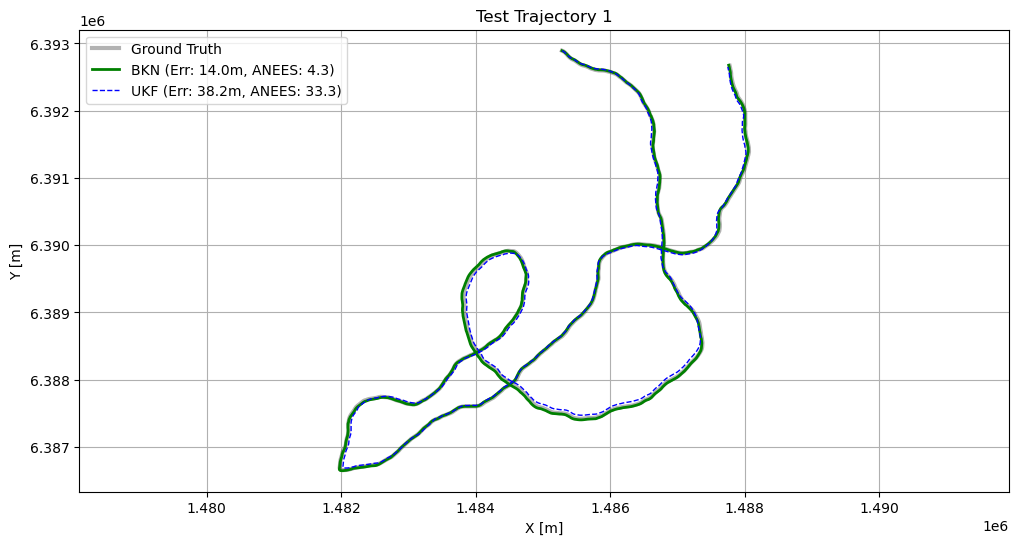

Evaluace:   5%|▌         | 1/20 [00:09<02:51,  9.01s/it]

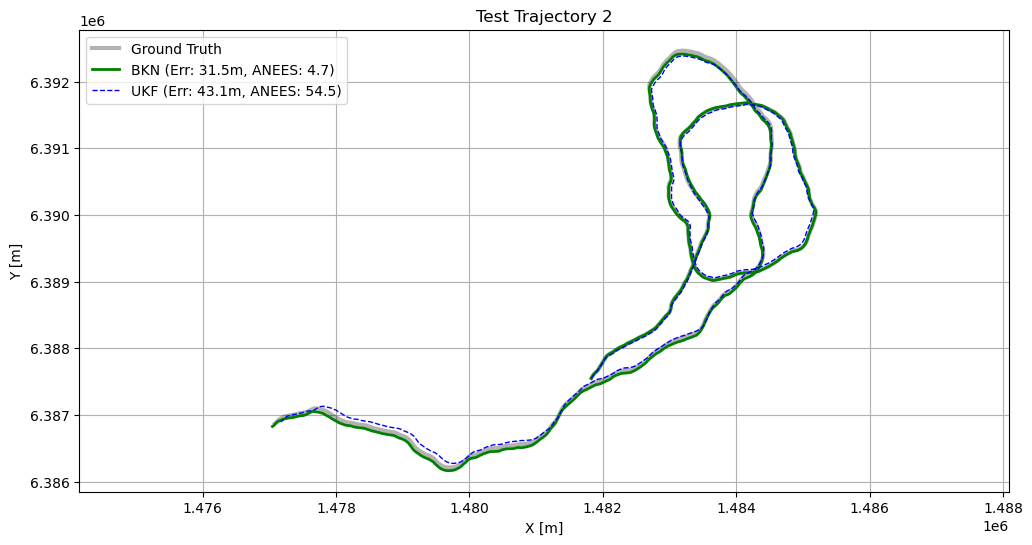

Evaluace:  10%|█         | 2/20 [00:19<02:53,  9.64s/it]


KeyboardInterrupt: 

In [24]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Filters
import os
from tqdm import tqdm
from Filters import TAN

# === KONFIGURACE ===
TEST_DATA_PATH = './generated_data_synthetic_controlled/test_set/test.pt'
PLOT_PER_ITERATION = True  # Vykreslovat graf pro každou trajektorii?
MAX_TEST_SAMPLES = 20        # Kolik trajektorií z test setu vyhodnotit
J_EVALUATION = 100           # Počet Monte Carlo vzorků pro BKN (Ensemble size)

print(f"=== VYHODNOCENÍ BKN NA TESTOVACÍ SADĚ (s ANEES) ===")
print(f"Načítám data z: {TEST_DATA_PATH}")

# 1. Načtení Testovací sady
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Soubor {TEST_DATA_PATH} neexistuje!")

# Předpokládáme, že 'device' je definováno
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_data = torch.load(TEST_DATA_PATH, map_location=device)
X_test_all = test_data['x']  # Ground Truth [N, Seq, 4]
Y_test_all = test_data['y']  # Measurements [N, Seq, 3]

n_samples = min(X_test_all.shape[0], MAX_TEST_SAMPLES)
print(f"Počet testovacích trajektorií: {n_samples}")
print(f"Ensemble size (BKN): {J_EVALUATION}")
print(f"Délka sekvence: {X_test_all.shape[1]}")
print("Modely: BKN vs. UKF vs. PF vs. APF")

# 2. Inicializace pro sběr dat
detailed_results = []
trajectory_history = []
agg_mse = {"BKN": [], "UKF": [], "PF": [], "APF": []}
agg_pos = {"BKN": [], "UKF": [], "PF": [], "APF": []}
agg_anees = {"BKN": [], "UKF": [], "PF": [], "APF": []} # Nový list pro ANEES

# Ujistíme se, že BKN je v eval módu 
state_knet2.eval() 

# --- POMOCNÁ FUNKCE PRO ANEES ---
def calculate_anees(gt, est, P):
    """
    Vypočítá Average Normalized Estimation Error Squared.
    gt: Ground Truth [T, Dim] (NumPy)
    est: Odhad [T, Dim] (NumPy)
    P: Kovarianční matice [T, Dim, Dim] (NumPy)
    """
    T = min(len(gt), len(est), len(P))
    anees_vals = []
    
    # Oříznutí na stejnou délku
    gt = gt[:T]
    est = est[:T]
    P = P[:T]
    
    for t in range(T):
        e_t = gt[t] - est[t] # Chyba v čase t
        P_t = P[t]
        
        try:
            # Inverze kovariance
            # Přičteme malé epsilon na diagonálu pro numerickou stabilitu, pokud je singulární
            if np.linalg.cond(P_t) > 1e10:
                P_t = P_t + np.eye(P_t.shape[0]) * 1e-6
                
            P_inv = np.linalg.inv(P_t)
            
            # Mahalanobisova vzdálenost: e^T * P^-1 * e
            anees_t = e_t.T @ P_inv @ e_t
            anees_vals.append(anees_t)
        except np.linalg.LinAlgError:
            anees_vals.append(np.nan)
            
    return np.nanmean(anees_vals)

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(n_samples), desc="Evaluace"):
    
    # A) Příprava dat
    x_gt_tensor = X_test_all[i].to(device)
    y_obs_tensor = Y_test_all[i].to(device)
    
    x_gt = x_gt_tensor.cpu().numpy()
    seq_len = x_gt.shape[0]
    true_init_state = x_gt_tensor[0] 
    
    # --- B) BKN (Ensemble) ---
    with torch.no_grad():
        init_batch = true_init_state.unsqueeze(0).repeat(J_EVALUATION, 1)
        state_knet2.reset(batch_size=J_EVALUATION, initial_state=init_batch)
        
        bkn_preds = []
        y_input_batch = y_obs_tensor.unsqueeze(0).repeat(J_EVALUATION, 1, 1)
        
        for t in range(1, seq_len):
            y_t = y_input_batch[:, t, :]
            x_est, _ = state_knet2.step(y_t) 
            bkn_preds.append(x_est)
            
        if len(bkn_preds) > 0:
            bkn_preds_tensor = torch.stack(bkn_preds, dim=1) # [J, Seq-1, 4]
            full_bkn_ensemble = torch.cat([init_batch.unsqueeze(1), bkn_preds_tensor], dim=1) # [J, Seq, 4]
            
            # Mean Estimate
            x_est_mean = full_bkn_ensemble.mean(dim=0)
            x_est_bkn = x_est_mean.cpu().numpy()
            
            # --- VÝPOČET KOVARIANCE PRO BKN ---
            # P = 1/(J-1) * sum((x_j - x_mean) * (x_j - x_mean)^T)
            # Vycentrování
            residuals = full_bkn_ensemble - x_est_mean.unsqueeze(0) # [J, Seq, 4]
            # Permute pro batch matmul: [Seq, J, 4] a [Seq, 4, J]
            residuals = residuals.permute(1, 2, 0) # [Seq, 4, J]
            
            # Batch matrix multiplication: (Seq, 4, J) @ (Seq, J, 4) -> (Seq, 4, 4)
            P_bkn_tensor = torch.bmm(residuals, residuals.transpose(1, 2)) / (J_EVALUATION - 1)
            # Přičtení process noise/stabilitu (volitelné, BKN variance je epistemická)
            P_bkn = P_bkn_tensor.cpu().numpy()
            
        else:
            x_est_bkn = x_gt
            P_bkn = np.eye(4)[np.newaxis, :, :].repeat(len(x_gt), axis=0)

    # --- C) Klasické Filtry ---
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(y_seq=y_obs_tensor, Ex0=true_init_state, P0=system_model.P0)
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()
    # Získání P pro UKF (zkusíme různé klíče)
    P_ukf = ukf_res.get('P_filtered', ukf_res.get('P', None))
    if P_ukf is not None: P_ukf = P_ukf.cpu().numpy()

    # PF
    pf = TAN.ParticleFilterTAN(system_model, num_particles=1000) 
    pf_res = pf.process_sequence(y_seq=y_obs_tensor, Ex0=true_init_state, P0=system_model.P0)
    x_est_pf = pf_res['x_filtered'].cpu().numpy()
    P_pf = pf_res.get('P_filtered', pf_res.get('P', None))
    if P_pf is not None: P_pf = P_pf.cpu().numpy()

    # APF
    apf = TAN.AuxiliaryParticleFilterTAN(system_model, num_particles=2000) 
    apf_res = apf.process_sequence(y_seq=y_obs_tensor, Ex0=true_init_state, P0=system_model.P0)
    x_est_apf = apf_res['x_filtered'].cpu().numpy()
    P_apf = apf_res.get('P_filtered', apf_res.get('P', None))
    if P_apf is not None: P_apf = P_apf.cpu().numpy()
    
    # --- D) Výpočet chyb a ANEES ---
    min_len = min(len(x_gt), len(x_est_bkn), len(x_est_ukf))
    
    def calc_metrics(est, gt, P_mat):
        diff = est[:min_len] - gt[:min_len]
        mse = np.mean(np.sum(diff[:, :2]**2, axis=1)) 
        pos_err = np.mean(np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
        
        anees = np.nan
        if P_mat is not None:
            anees = calculate_anees(gt[:min_len], est[:min_len], P_mat[:min_len])
            
        return mse, pos_err, anees

    # Calculate for all
    mse_bkn, pos_bkn, anees_bkn = calc_metrics(x_est_bkn, x_gt, P_bkn)
    mse_ukf, pos_ukf, anees_ukf = calc_metrics(x_est_ukf, x_gt, P_ukf)
    mse_pf, pos_pf, anees_pf = calc_metrics(x_est_pf, x_gt, P_pf)
    mse_apf, pos_apf, anees_apf = calc_metrics(x_est_apf, x_gt, P_apf)
    
    # Uložení
    agg_mse["BKN"].append(mse_bkn); agg_pos["BKN"].append(pos_bkn); agg_anees["BKN"].append(anees_bkn)
    agg_mse["UKF"].append(mse_ukf); agg_pos["UKF"].append(pos_ukf); agg_anees["UKF"].append(anees_ukf)
    agg_mse["PF"].append(mse_pf);   agg_pos["PF"].append(pos_pf);   agg_anees["PF"].append(anees_pf)
    agg_mse["APF"].append(mse_apf); agg_pos["APF"].append(pos_apf); agg_anees["APF"].append(anees_apf)

    detailed_results.append({
        "Run_ID": i + 1,
        "BKN_PosErr": pos_bkn, "BKN_ANEES": anees_bkn,
        "UKF_PosErr": pos_ukf, "UKF_ANEES": anees_ukf,
        "PF_PosErr": pos_pf,   "PF_ANEES": anees_pf,
        "APF_PosErr": pos_apf, "APF_ANEES": anees_apf
    })
    
    if i < 2:  # Uložíme detailní časovou historii pro první 2 trajektorie
        trajectory_history.append({
            "gt": x_gt,
            "bkn_est": x_est_bkn,
            "bkn_P": P_bkn,
            "ukf_est": x_est_ukf,
            "ukf_P": P_ukf
        })
    # E) Vykreslení
    if PLOT_PER_ITERATION:
        fig = plt.figure(figsize=(12, 6))
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        plt.plot(x_est_bkn[:, 0], x_est_bkn[:, 1], 'g-', linewidth=2, label=f'BKN (Err: {pos_bkn:.1f}m, ANEES: {anees_bkn:.1f})')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_ukf:.1f}m, ANEES: {anees_ukf:.1f})')
        # Pro přehlednost vykreslíme jen BKN a UKF, případně odkomentujte PF/APF
        # plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.6, label='PF')
        plt.title(f"Test Trajectory {i+1}")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*120)
print(f"DETAILNÍ VÝSLEDKY (Pozice v metrech | ANEES - ideál ~4.0)")
print("="*120)
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "BKN_PosErr", "BKN_ANEES", "UKF_PosErr", "UKF_ANEES", "PF_PosErr", "APF_PosErr"]])

print("\n" + "="*120)
print(f"SOUHRNNÁ STATISTIKA ({n_samples} trajektorií)")
print("="*120)

def get_stats(key):
    return (np.nanmean(agg_mse[key]), np.nanstd(agg_mse[key]), 
            np.nanmean(agg_pos[key]), np.nanstd(agg_pos[key]),
            np.nanmean(agg_anees[key]), np.nanstd(agg_anees[key]))

bkn_s = get_stats("BKN")
ukf_s = get_stats("UKF")
pf_s = get_stats("PF")
apf_s = get_stats("APF")

# Formátování tabulky
header = f"{'Model':<10} | {'Pos Error [m] (Mean ± Std)':<30} | {'ANEES (Mean ± Std)':<30}"
print(header)
print("-" * len(header))
print(f"{'BKN':<10} | {bkn_s[2]:.2f} ± {bkn_s[3]:.2f} m {'':<14} | {bkn_s[4]:.2f} ± {bkn_s[5]:.2f}")
print(f"{'UKF':<10} | {ukf_s[2]:.2f} ± {ukf_s[3]:.2f} m {'':<14} | {ukf_s[4]:.2f} ± {ukf_s[5]:.2f}")
print(f"{'PF':<10} | {pf_s[2]:.2f} ± {pf_s[3]:.2f} m {'':<14} | {pf_s[4]:.2f} ± {pf_s[5]:.2f}")
print(f"{'APF':<10} | {apf_s[2]:.2f} ± {apf_s[3]:.2f} m {'':<14} | {apf_s[4]:.2f} ± {apf_s[5]:.2f}")
print("="*120)

# Grafické porovnání (Boxplot Position Error)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.boxplot([agg_pos["BKN"], agg_pos["UKF"], agg_pos["PF"]], labels=['BKN', 'UKF', 'PF'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Position Error [m]")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Grafické porovnání (Boxplot ANEES)
plt.subplot(1, 2, 2)
# Filtrujeme NaN pro boxplot
anees_data = [
    [x for x in agg_anees["BKN"] if not np.isnan(x)],
    [x for x in agg_anees["UKF"] if not np.isnan(x)],
    [x for x in agg_anees["PF"] if not np.isnan(x)]
]
plt.boxplot(anees_data, labels=['BKN', 'UKF', 'PF'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.axhline(y=4.0, color='r', linestyle='--', label='Ideal (4.0)')
plt.title("ANEES (Consistency)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

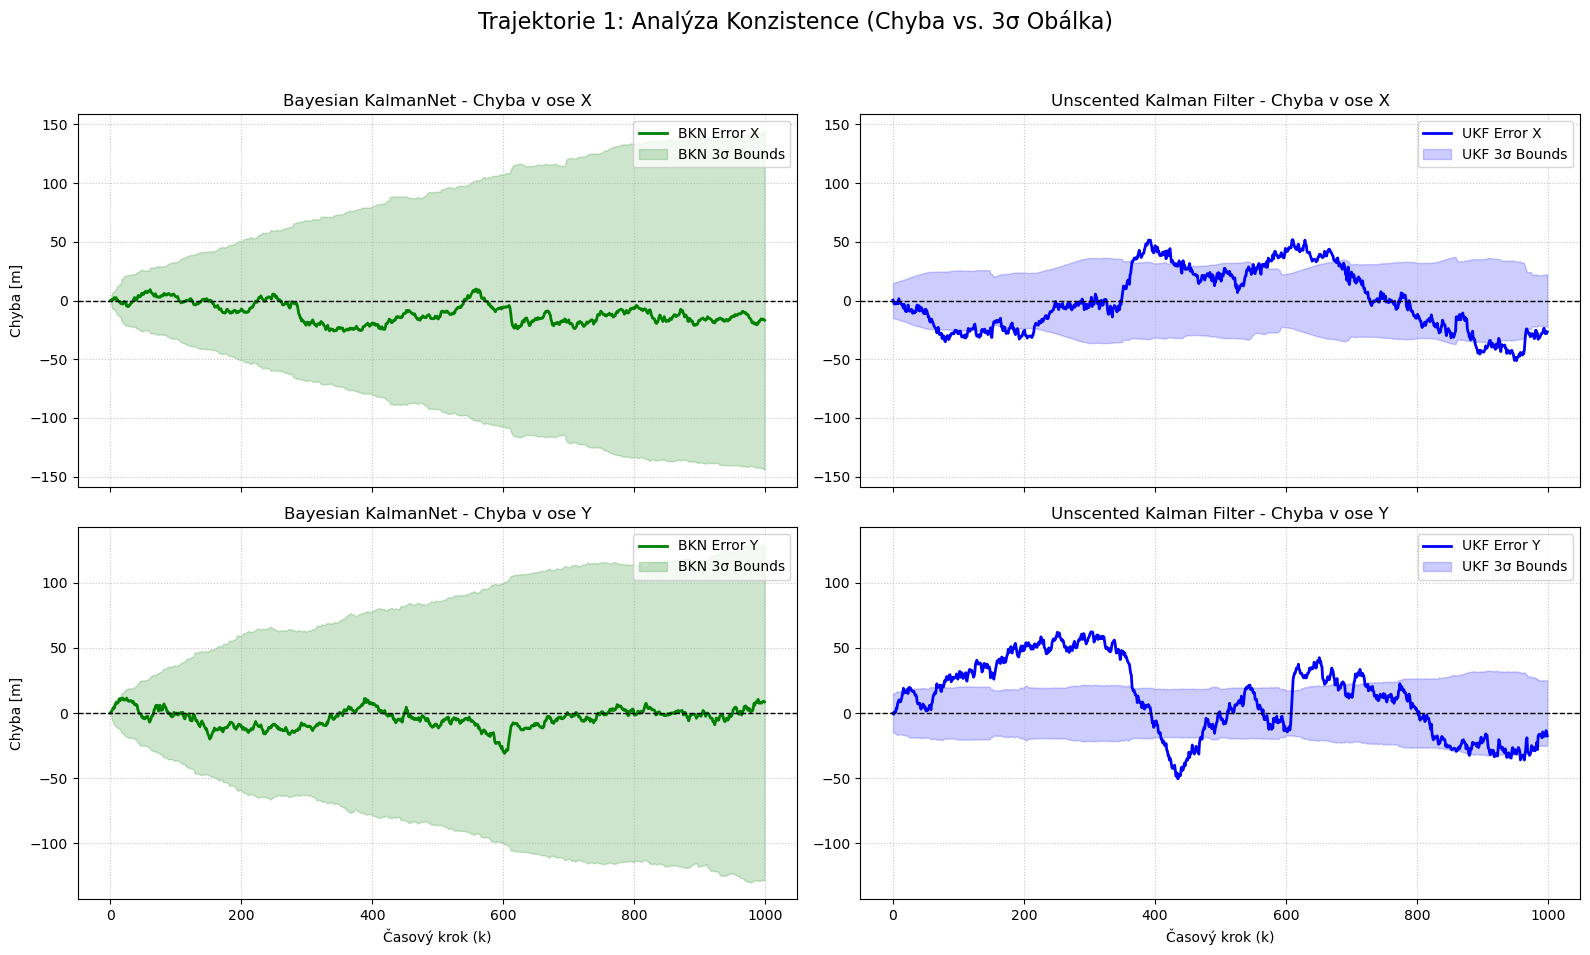

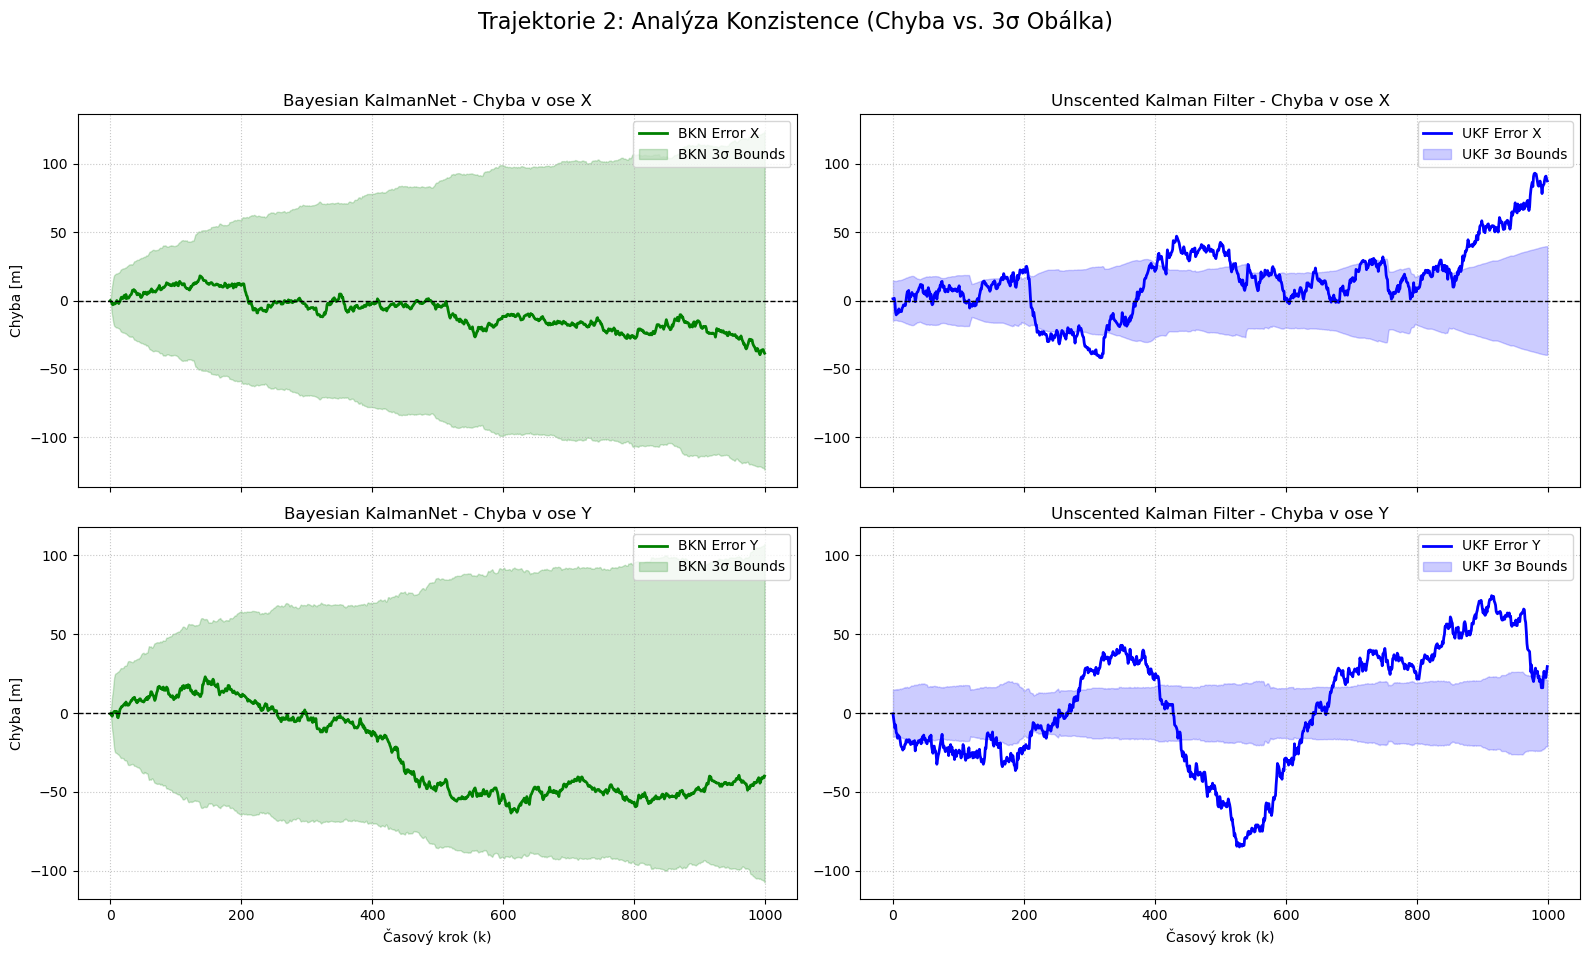

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Zkontrolujeme, zda máme uložená data z předchozí buňky
if 'trajectory_history' not in globals() or len(trajectory_history) < 2:
    print("⚠️ Chyba: Chybí data 'trajectory_history'. Ujisti se, že jsi provedl úpravu v hlavní smyčce.")
else:
    for traj_idx in range(2):
        data = trajectory_history[traj_idx]
        
        gt = data["gt"]
        bkn_est = data["bkn_est"]
        bkn_P = data["bkn_P"]
        ukf_est = data["ukf_est"]
        ukf_P = data["ukf_P"]
        
        seq_len = min(len(gt), len(bkn_est), len(ukf_est))
        time_steps = np.arange(seq_len)
        
        # Výpočet odchylek (Error = Odhad - Skutečnost)
        err_bkn_x = bkn_est[:seq_len, 0] - gt[:seq_len, 0]
        err_bkn_y = bkn_est[:seq_len, 1] - gt[:seq_len, 1]
        
        err_ukf_x = ukf_est[:seq_len, 0] - gt[:seq_len, 0]
        err_ukf_y = ukf_est[:seq_len, 1] - gt[:seq_len, 1]
        
        # Výpočet 3-sigma mezí z kovariančních matic
        # (index 0,0 je variance X; index 1,1 je variance Y)
        std_bkn_x = np.sqrt(bkn_P[:seq_len, 0, 0])
        std_bkn_y = np.sqrt(bkn_P[:seq_len, 1, 1])
        
        std_ukf_x = np.sqrt(ukf_P[:seq_len, 0, 0])
        std_ukf_y = np.sqrt(ukf_P[:seq_len, 1, 1])

        # --- VYKRESLOVÁNÍ ---
        fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
        fig.suptitle(f'Trajektorie {traj_idx + 1}: Analýza Konzistence (Chyba vs. 3σ Obálka)', fontsize=16)

        # 1. BKN - Poloha X
        axs[0, 0].plot(time_steps, err_bkn_x, 'g-', linewidth=2, label='BKN Error X')
        axs[0, 0].fill_between(time_steps, -3*std_bkn_x, 3*std_bkn_x, color='green', alpha=0.2, label='BKN 3σ Bounds')
        axs[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[0, 0].set_title('Bayesian KalmanNet - Chyba v ose X')
        axs[0, 0].set_ylabel('Chyba [m]')
        axs[0, 0].legend(loc='upper right')
        axs[0, 0].grid(True, linestyle=':', alpha=0.7)

        # 2. BKN - Poloha Y
        axs[1, 0].plot(time_steps, err_bkn_y, 'g-', linewidth=2, label='BKN Error Y')
        axs[1, 0].fill_between(time_steps, -3*std_bkn_y, 3*std_bkn_y, color='green', alpha=0.2, label='BKN 3σ Bounds')
        axs[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[1, 0].set_title('Bayesian KalmanNet - Chyba v ose Y')
        axs[1, 0].set_xlabel('Časový krok (k)')
        axs[1, 0].set_ylabel('Chyba [m]')
        axs[1, 0].legend(loc='upper right')
        axs[1, 0].grid(True, linestyle=':', alpha=0.7)

        # 3. UKF - Poloha X
        axs[0, 1].plot(time_steps, err_ukf_x, 'b-', linewidth=2, label='UKF Error X')
        axs[0, 1].fill_between(time_steps, -3*std_ukf_x, 3*std_ukf_x, color='blue', alpha=0.2, label='UKF 3σ Bounds')
        axs[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[0, 1].set_title('Unscented Kalman Filter - Chyba v ose X')
        axs[0, 1].legend(loc='upper right')
        axs[0, 1].grid(True, linestyle=':', alpha=0.7)

        # 4. UKF - Poloha Y
        axs[1, 1].plot(time_steps, err_ukf_y, 'b-', linewidth=2, label='UKF Error Y')
        axs[1, 1].fill_between(time_steps, -3*std_ukf_y, 3*std_ukf_y, color='blue', alpha=0.2, label='UKF 3σ Bounds')
        axs[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[1, 1].set_title('Unscented Kalman Filter - Chyba v ose Y')
        axs[1, 1].set_xlabel('Časový krok (k)')
        axs[1, 1].legend(loc='upper right')
        axs[1, 1].grid(True, linestyle=':', alpha=0.7)

        # Sladění Y-os pro spravedlivé porovnání mezi BKN a UKF
        max_y_val_x = max(np.max(np.abs(err_bkn_x)), np.max(3*std_bkn_x), np.max(np.abs(err_ukf_x)), np.max(3*std_ukf_x)) * 1.1
        max_y_val_y = max(np.max(np.abs(err_bkn_y)), np.max(3*std_bkn_y), np.max(np.abs(err_ukf_y)), np.max(3*std_ukf_y)) * 1.1
        
        axs[0, 0].set_ylim(-max_y_val_x, max_y_val_x)
        axs[0, 1].set_ylim(-max_y_val_x, max_y_val_x)
        axs[1, 0].set_ylim(-max_y_val_y, max_y_val_y)
        axs[1, 1].set_ylim(-max_y_val_y, max_y_val_y)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

## Ensamble update

=== VYHODNOCENÍ BKN NA TESTOVACÍ SADĚ (s ANEES) ===
Načítám data z: ./generated_data_synthetic_controlled/test_set/test.pt
Počet testovacích trajektorií: 20
Ensemble size (BKN): 100
Délka sekvence: 1000
Modely: BKN vs. UKF vs. PF vs. APF


Evaluace:   0%|          | 0/20 [00:00<?, ?it/s]

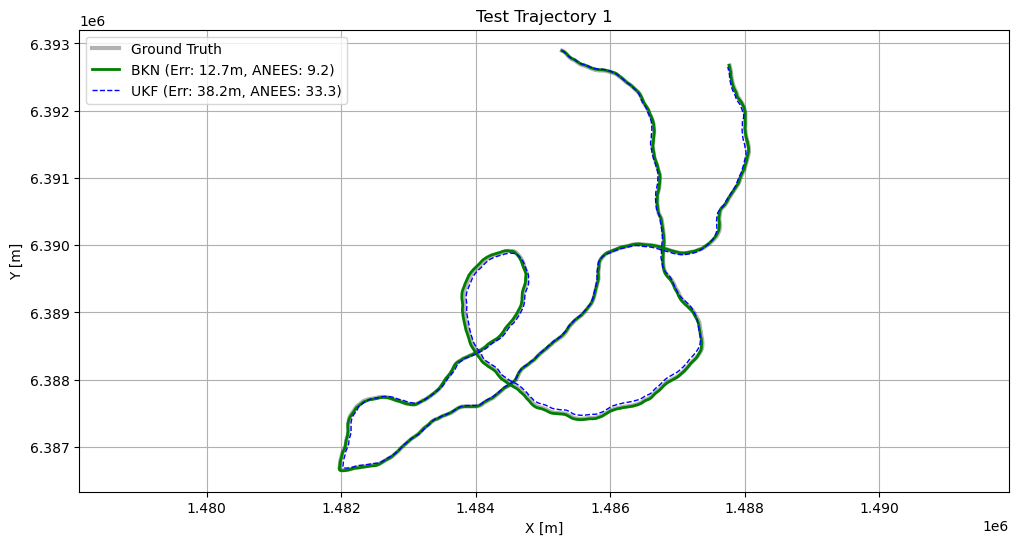

Evaluace:   5%|▌         | 1/20 [00:08<02:43,  8.61s/it]

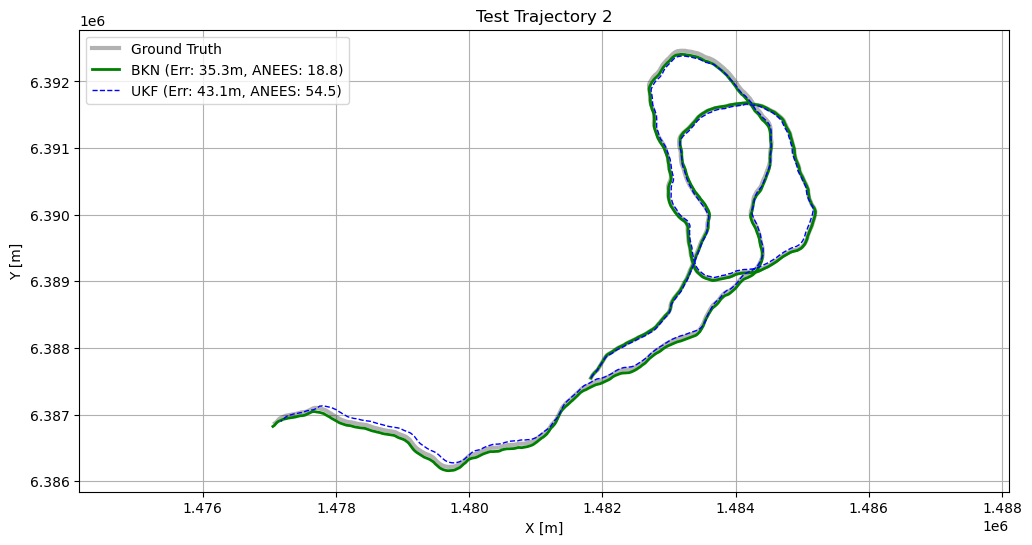

Evaluace:  10%|█         | 2/20 [00:17<02:33,  8.50s/it]

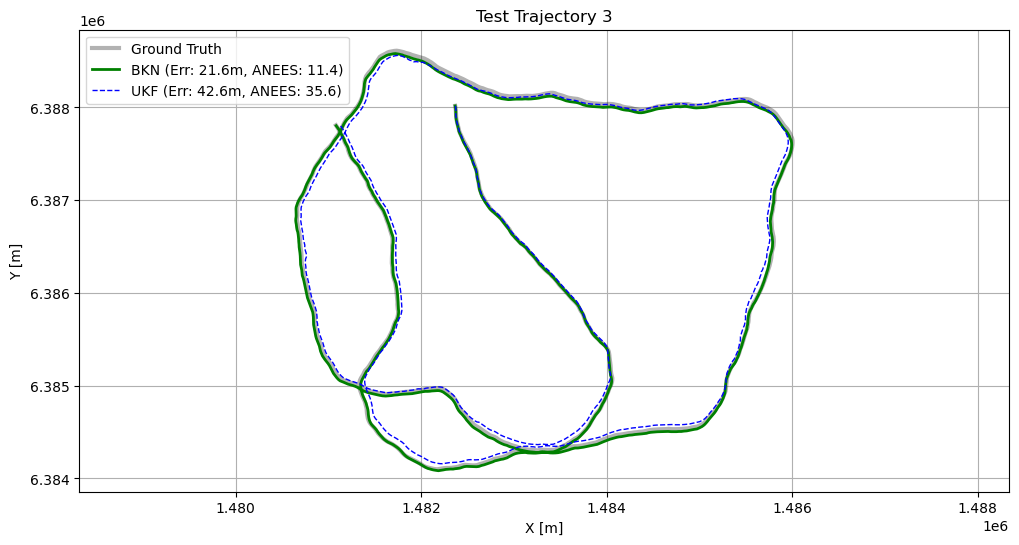

Evaluace:  15%|█▌        | 3/20 [00:25<02:23,  8.47s/it]

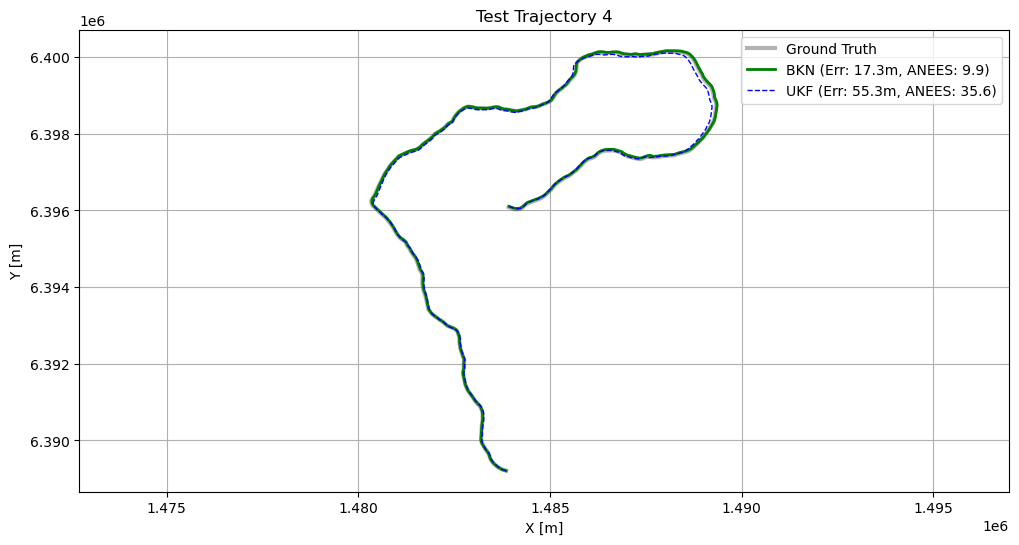

Evaluace:  20%|██        | 4/20 [00:34<02:17,  8.58s/it]

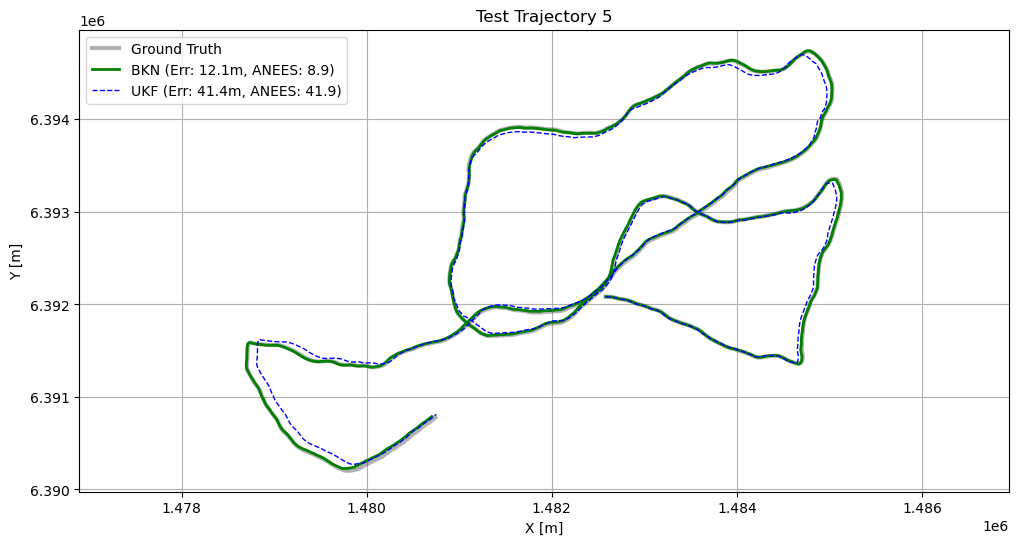

Evaluace:  25%|██▌       | 5/20 [00:42<02:07,  8.52s/it]

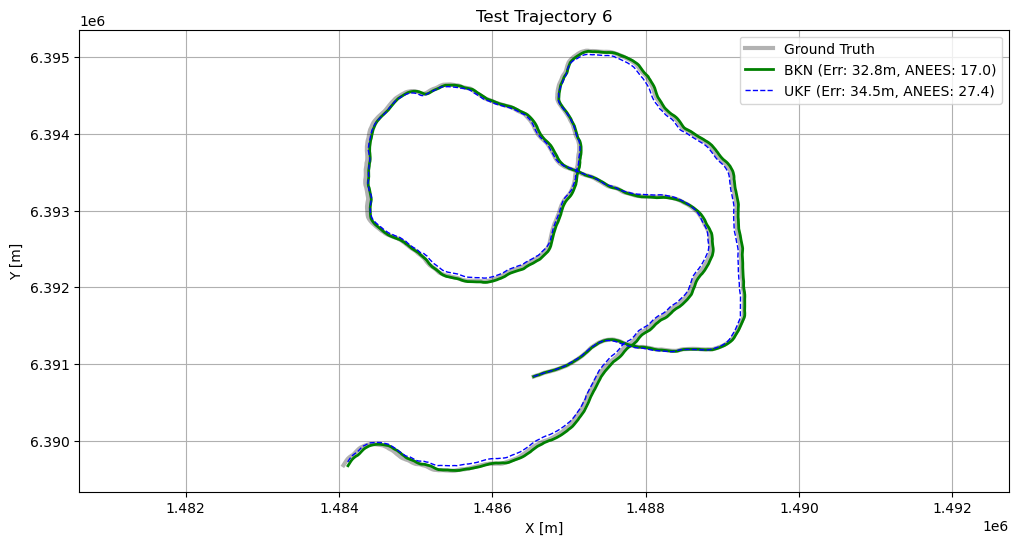

Evaluace:  30%|███       | 6/20 [00:51<01:59,  8.53s/it]

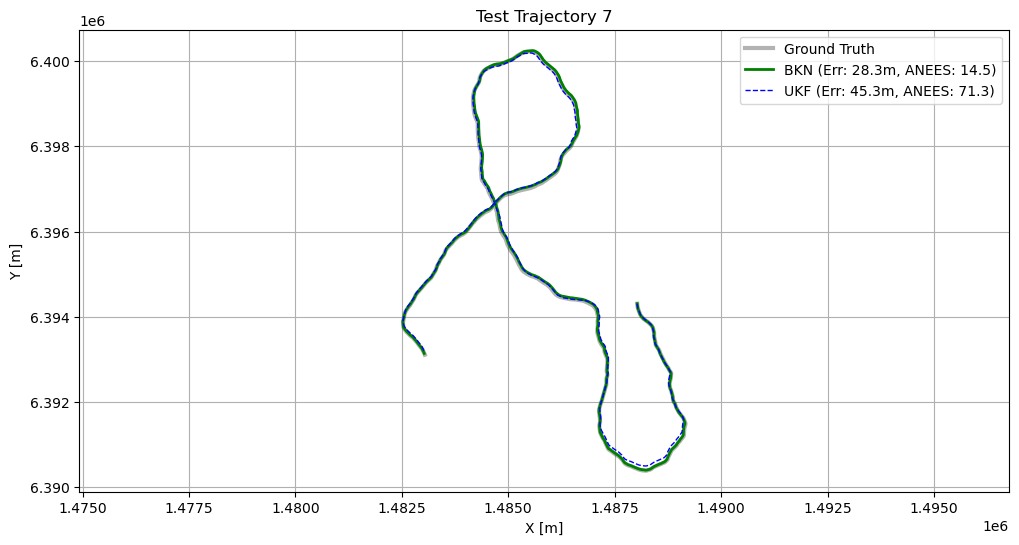

Evaluace:  35%|███▌      | 7/20 [01:00<01:52,  8.65s/it]

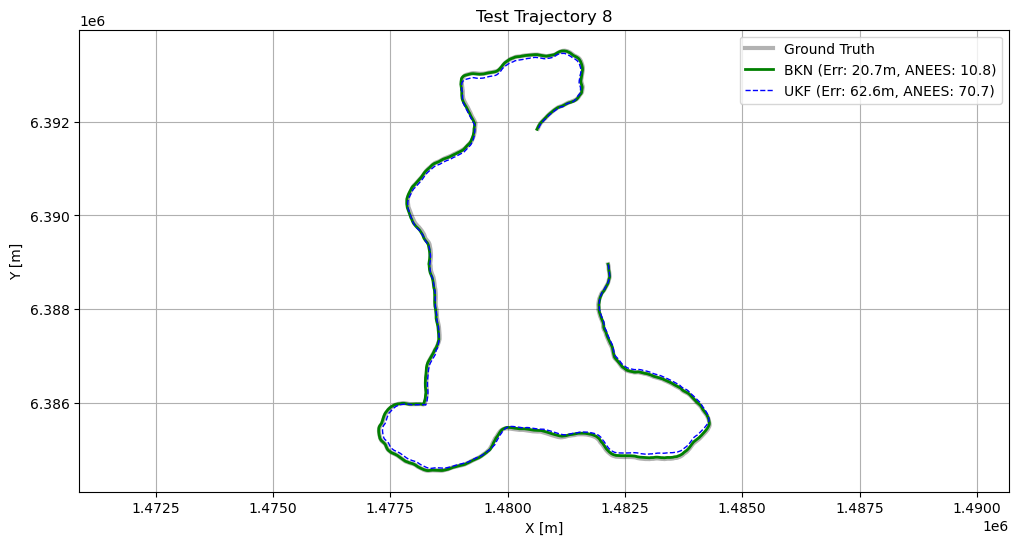

Evaluace:  40%|████      | 8/20 [01:08<01:42,  8.58s/it]

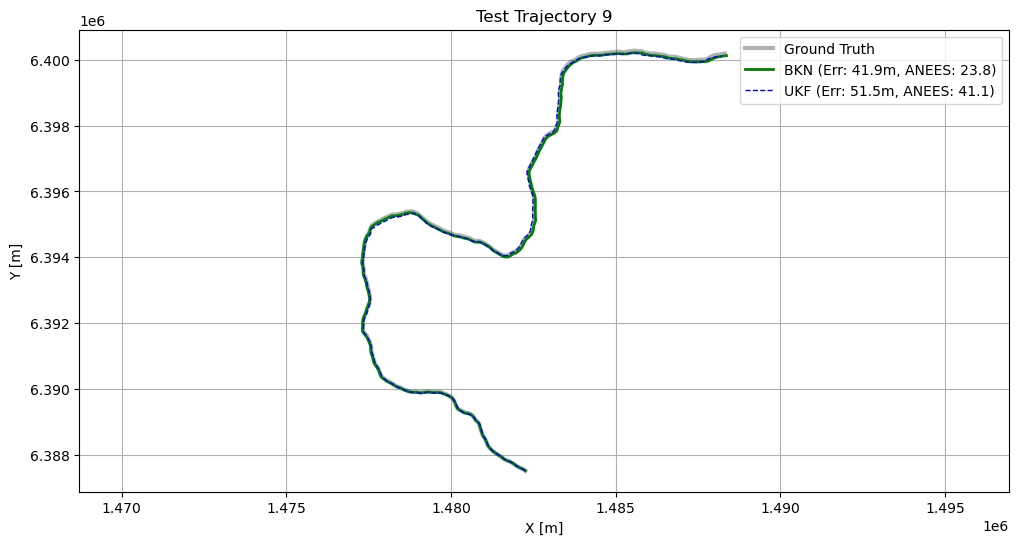

Evaluace:  45%|████▌     | 9/20 [01:17<01:36,  8.78s/it]

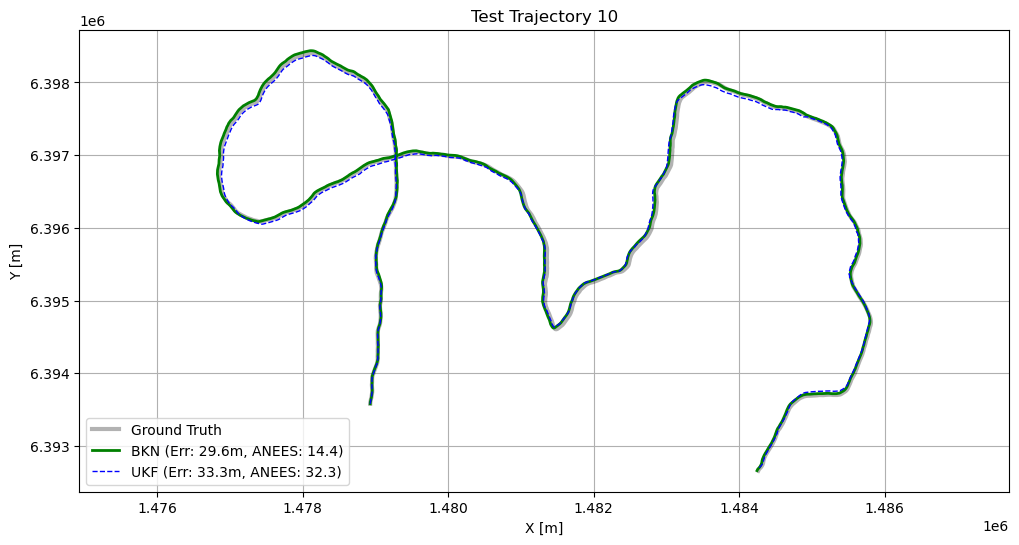

Evaluace:  50%|█████     | 10/20 [01:26<01:28,  8.82s/it]

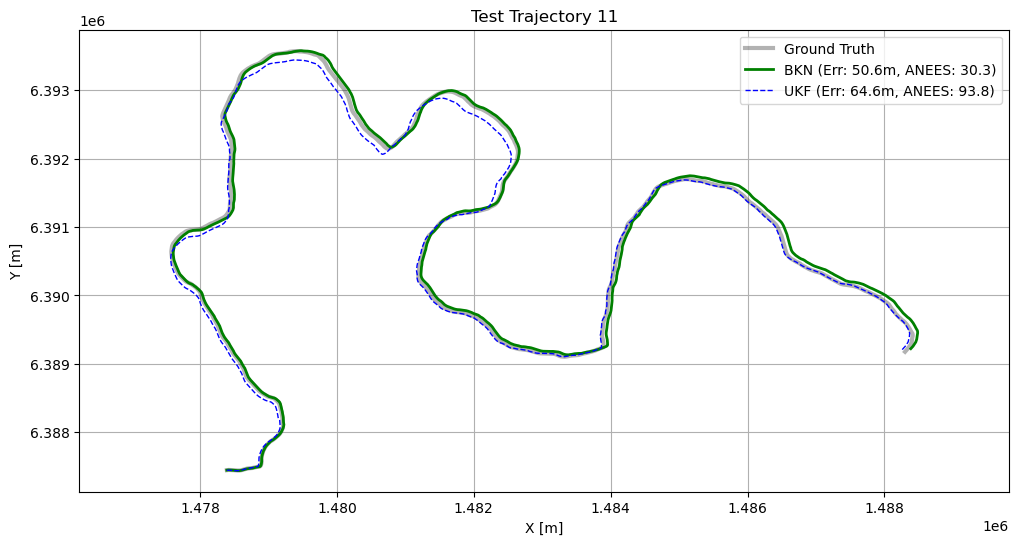

Evaluace:  55%|█████▌    | 11/20 [01:35<01:19,  8.83s/it]

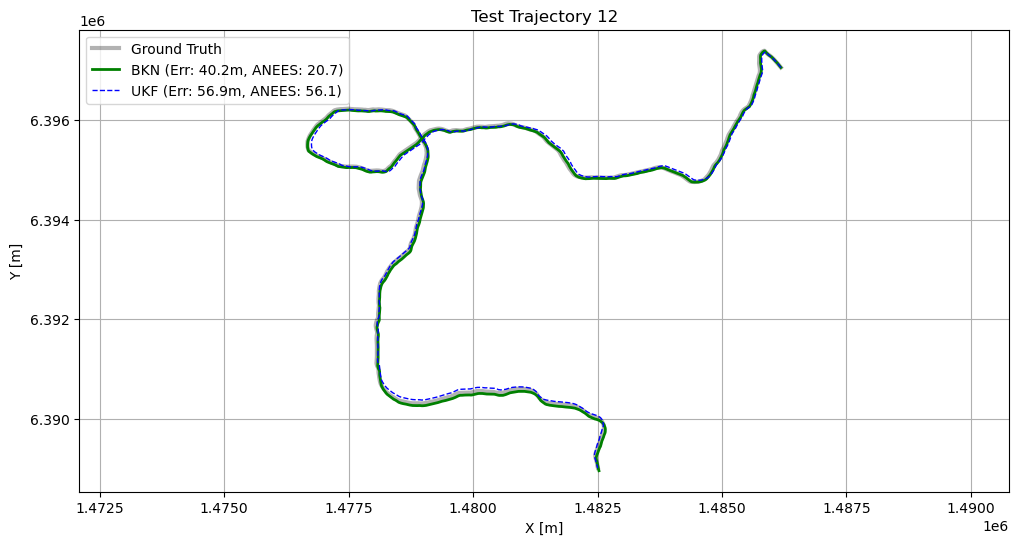

Evaluace:  60%|██████    | 12/20 [01:45<01:12,  9.10s/it]

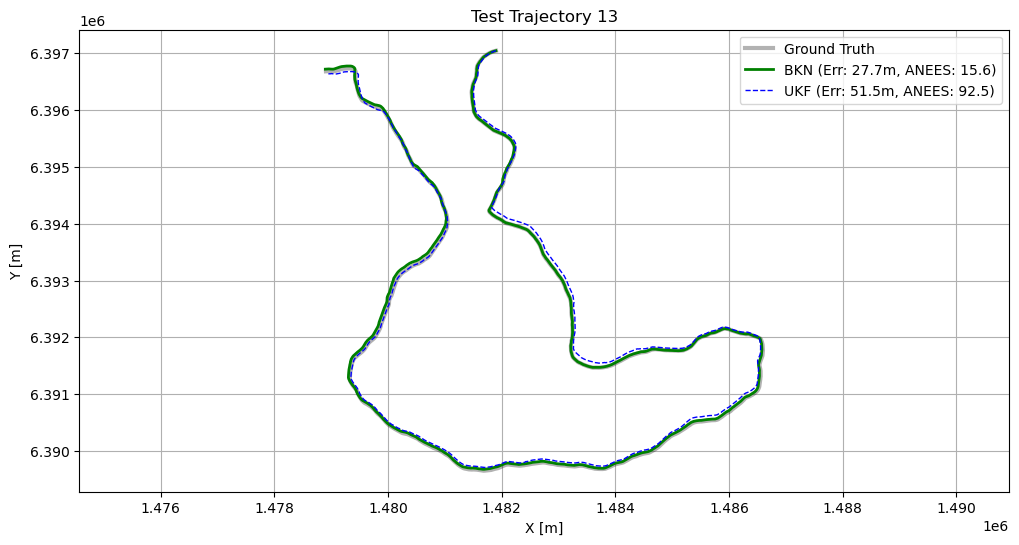

Evaluace:  65%|██████▌   | 13/20 [01:54<01:04,  9.24s/it]

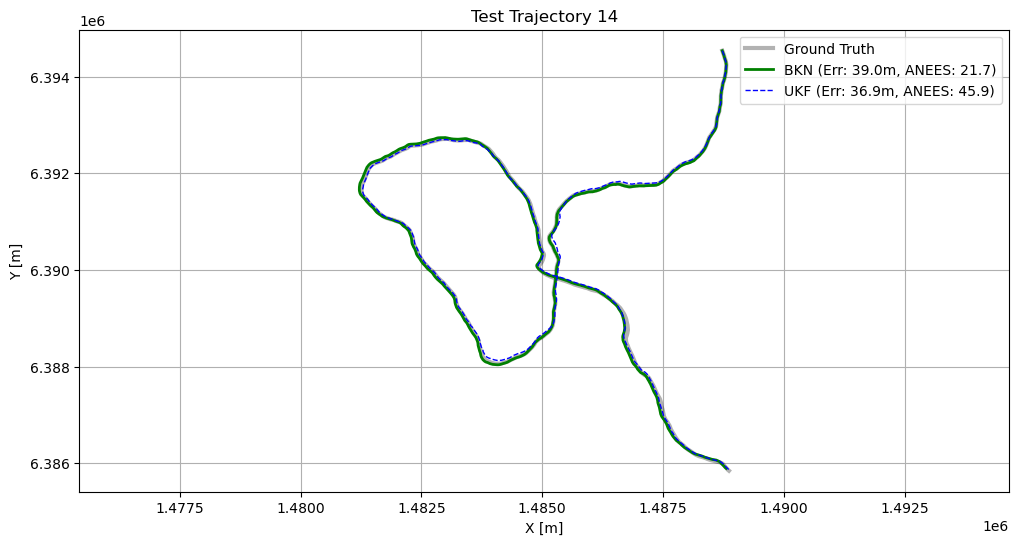

Evaluace:  70%|███████   | 14/20 [02:04<00:56,  9.41s/it]

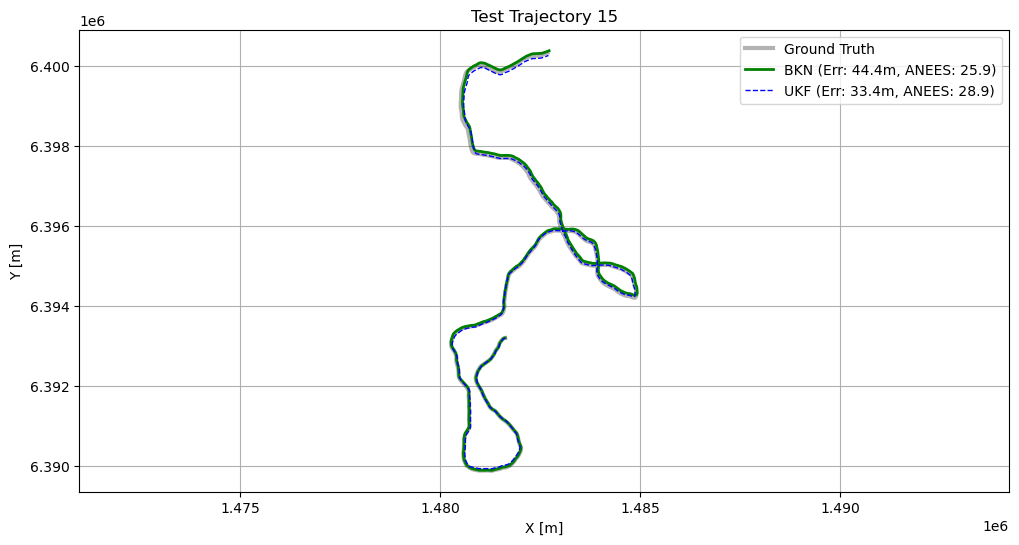

Evaluace:  75%|███████▌  | 15/20 [02:14<00:47,  9.57s/it]

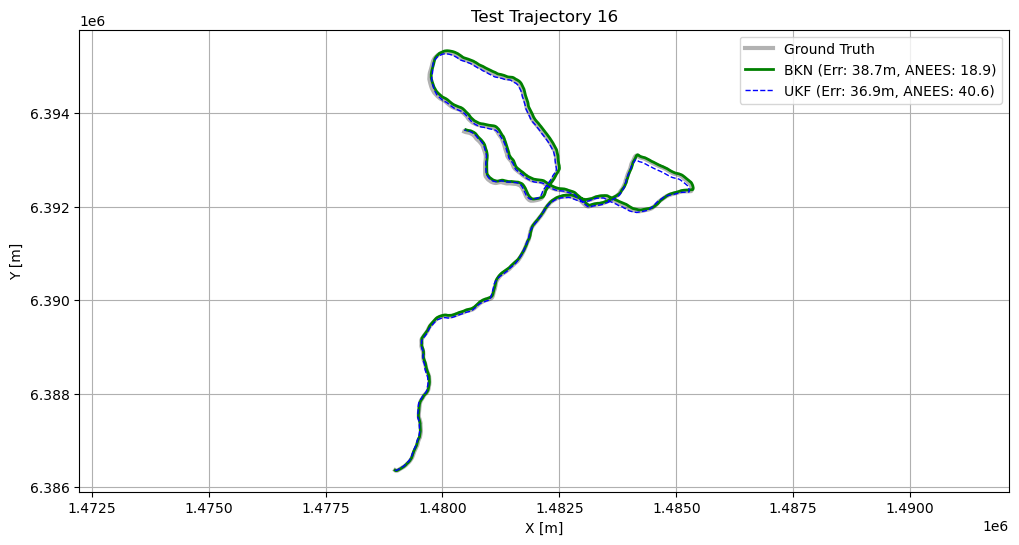

Evaluace:  80%|████████  | 16/20 [02:23<00:37,  9.45s/it]

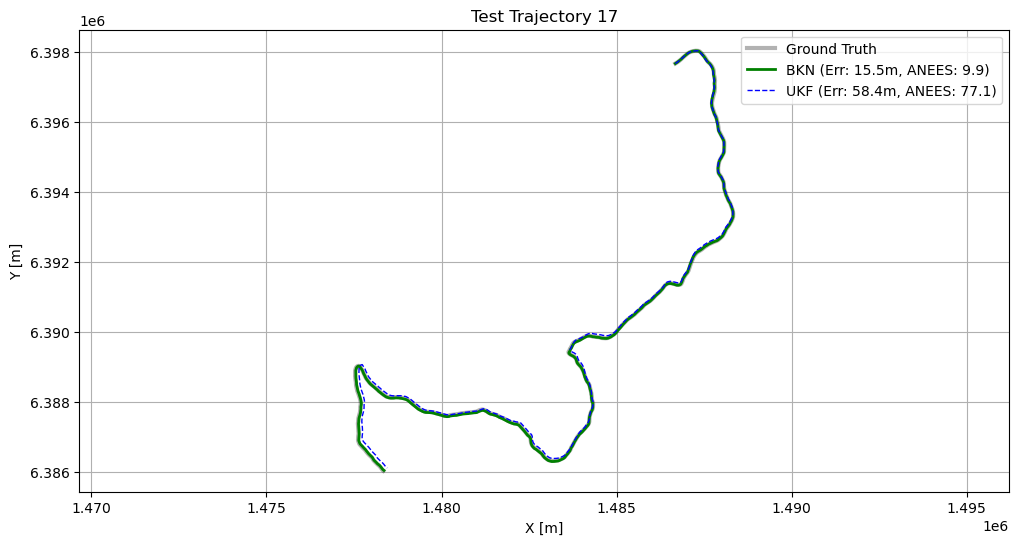

Evaluace:  85%|████████▌ | 17/20 [02:32<00:27,  9.21s/it]

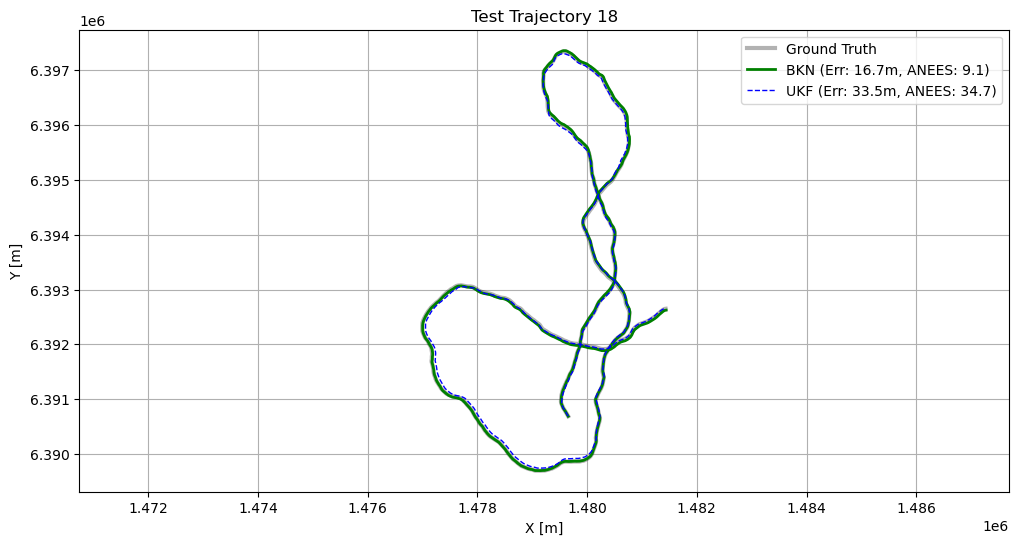

Evaluace:  90%|█████████ | 18/20 [02:41<00:18,  9.19s/it]

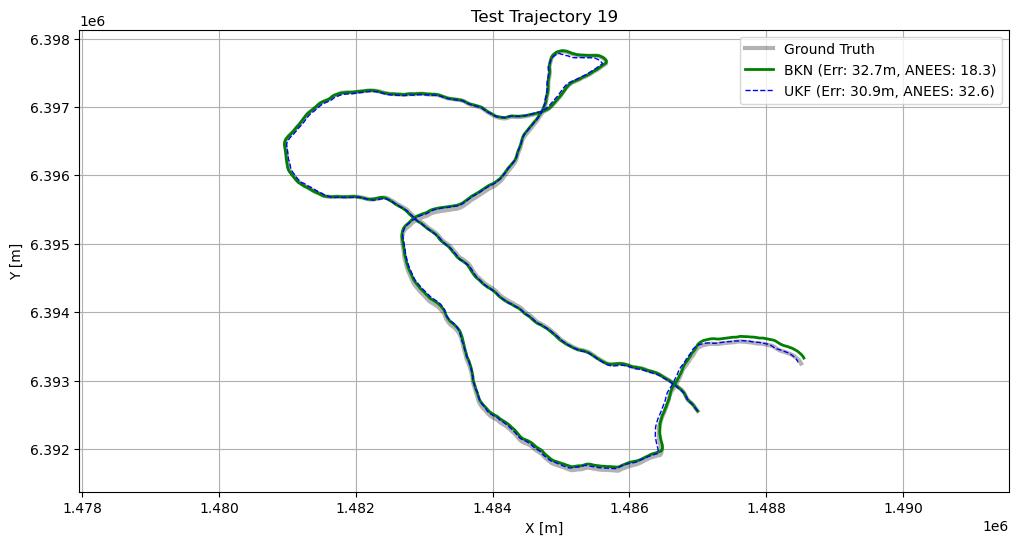

Evaluace:  95%|█████████▌| 19/20 [02:50<00:09,  9.29s/it]

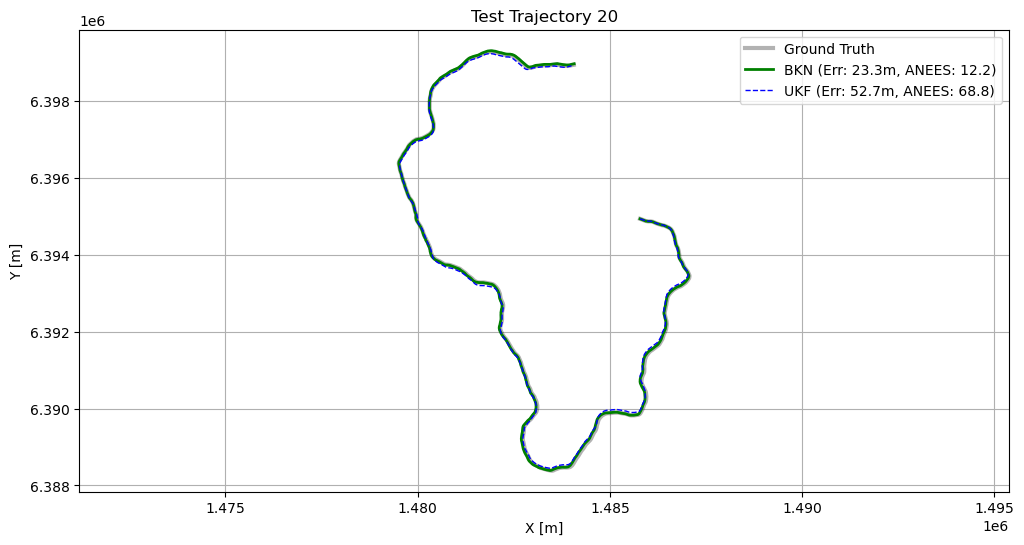

Evaluace: 100%|██████████| 20/20 [03:00<00:00,  9.02s/it]


DETAILNÍ VÝSLEDKY (Pozice v metrech | ANEES - ideál ~4.0)
    Run_ID  BKN_PosErr  BKN_ANEES  UKF_PosErr  UKF_ANEES  PF_PosErr  \
0        1       12.69       9.23       38.17      33.33   4,107.43   
1        2       35.33      18.78       43.13      54.50     416.49   
2        3       21.56      11.41       42.63      35.61     511.77   
3        4       17.32       9.88       55.35      35.62     939.57   
4        5       12.15       8.90       41.38      41.92   7,895.94   
5        6       32.81      17.05       34.53      27.40      59.00   
6        7       28.28      14.48       45.29      71.28     395.39   
7        8       20.68      10.77       62.59      70.68   3,265.88   
8        9       41.94      23.77       51.53      41.13      37.75   
9       10       29.55      14.38       33.32      32.27   2,837.53   
10      11       50.63      30.32       64.65      93.80   3,231.21   
11      12       40.16      20.72       56.92      56.08  13,923.95   
12      13       2

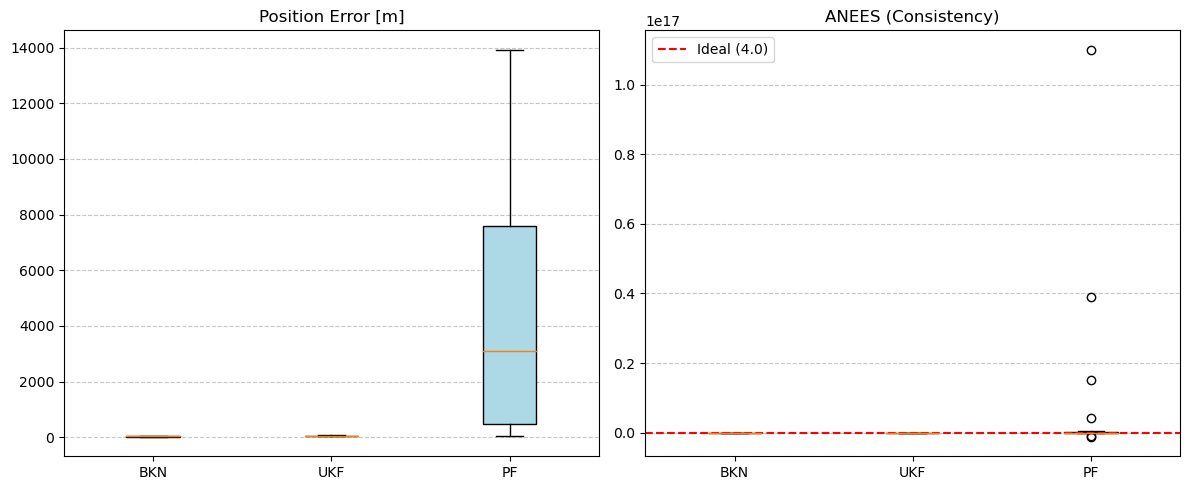

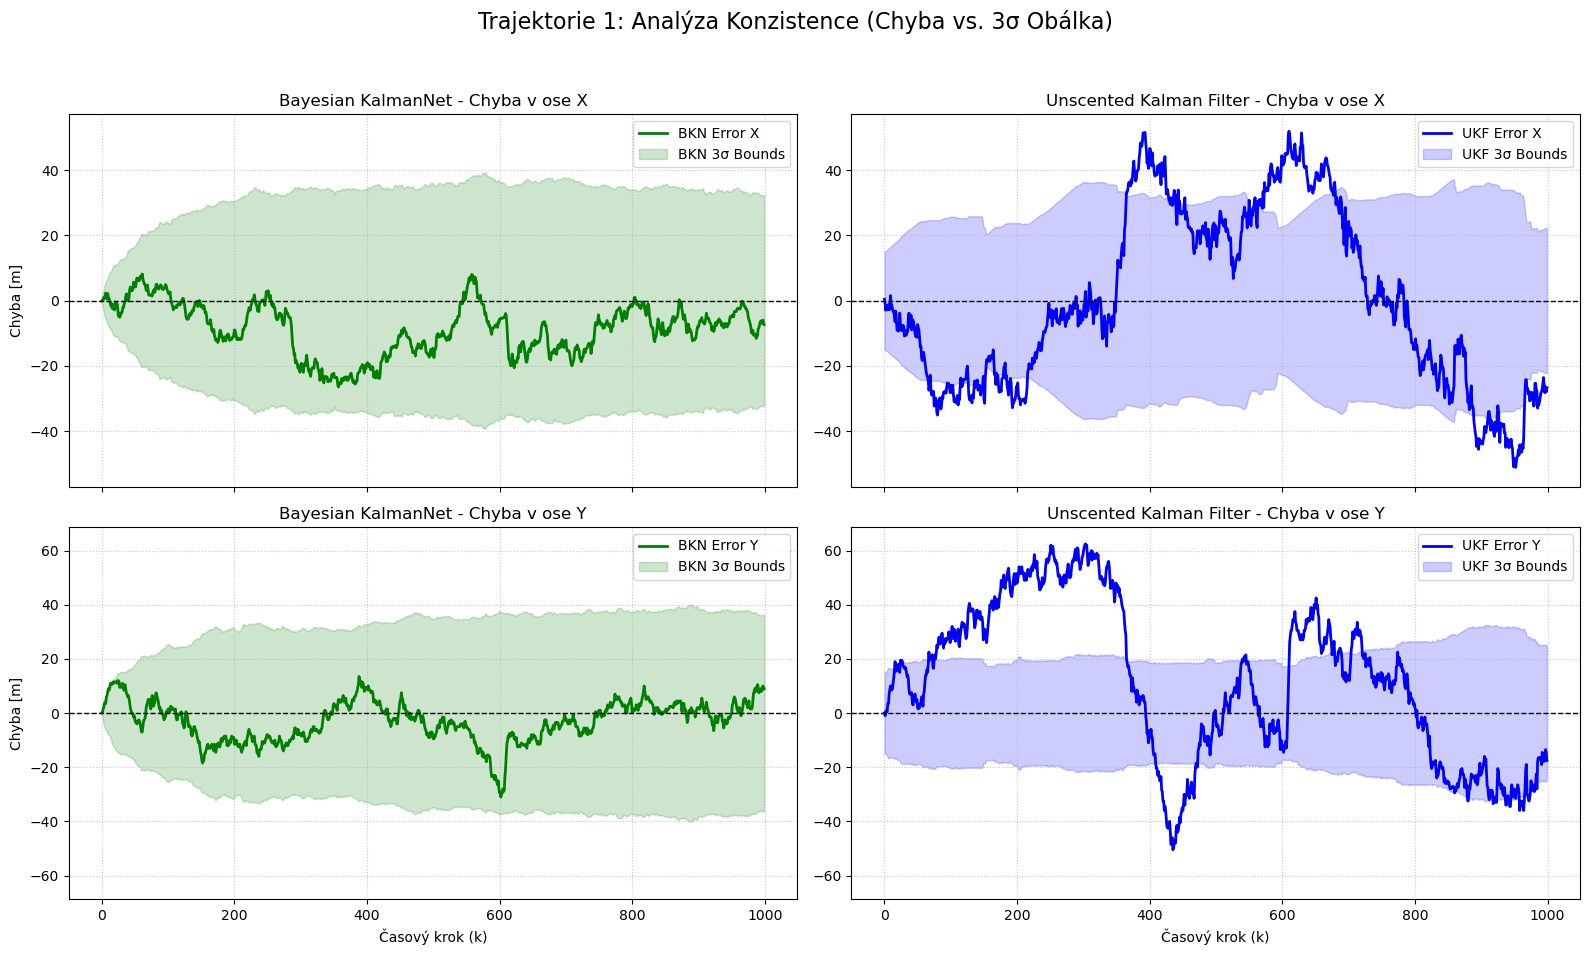

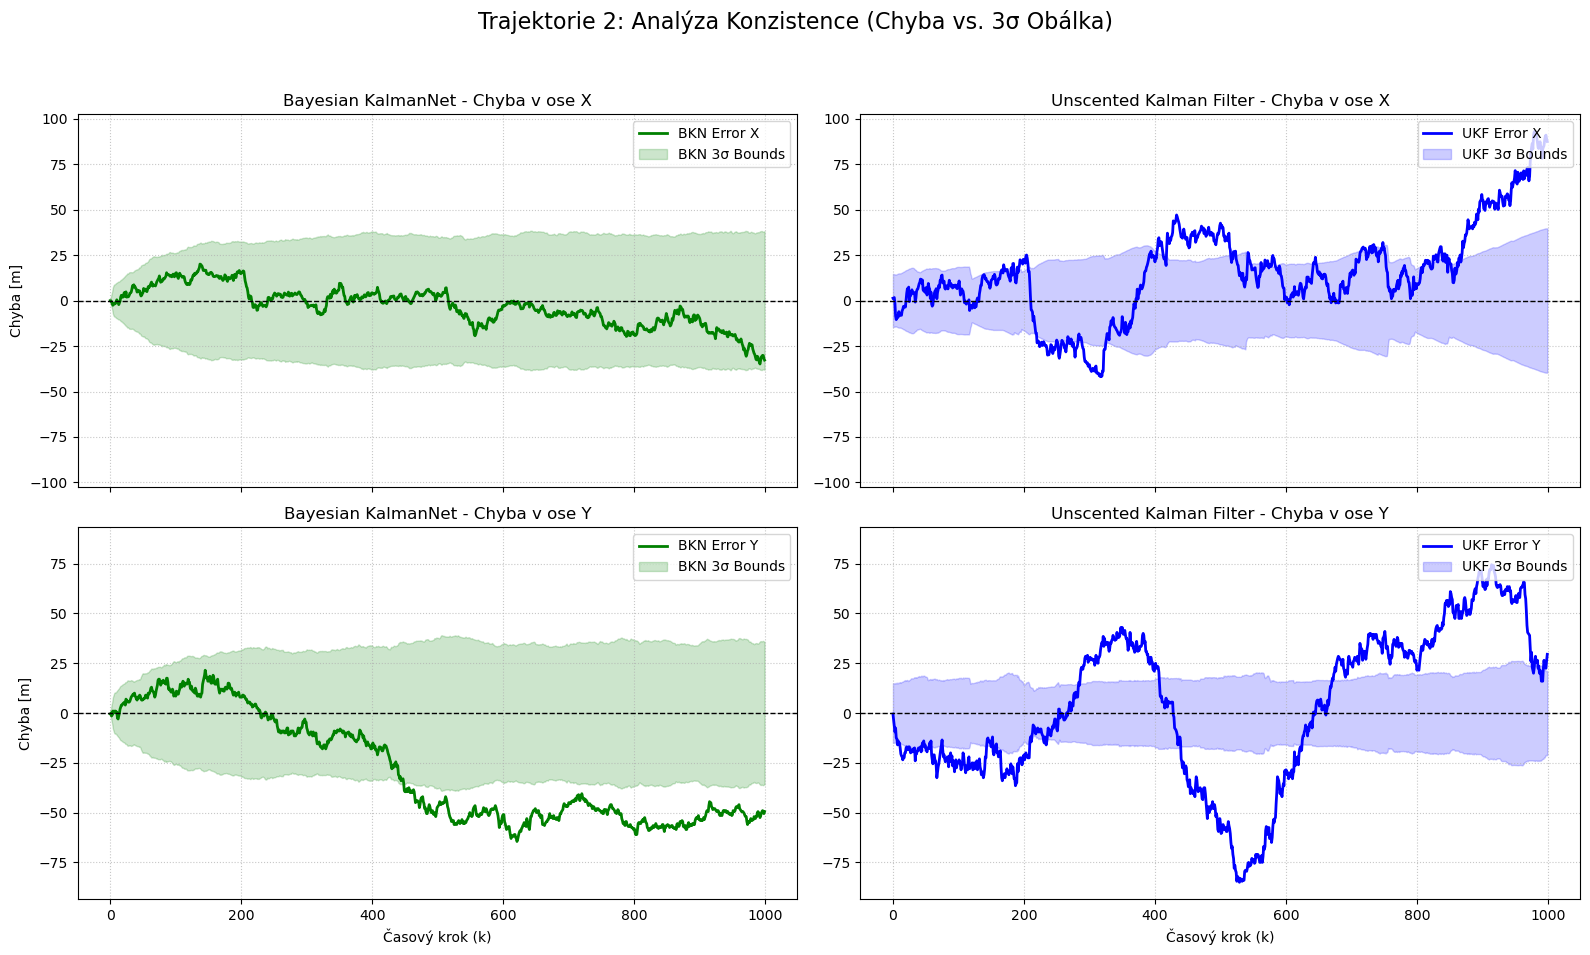

In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Filters
import os
from tqdm import tqdm
from Filters import TAN

# === KONFIGURACE ===
TEST_DATA_PATH = './generated_data_synthetic_controlled/test_set/test.pt'
PLOT_PER_ITERATION = True  # Vykreslovat graf pro každou trajektorii?
MAX_TEST_SAMPLES = 20        # Kolik trajektorií z test setu vyhodnotit
J_EVALUATION = 100           # Počet Monte Carlo vzorků pro BKN (Ensemble size)

print(f"=== VYHODNOCENÍ BKN NA TESTOVACÍ SADĚ (s ANEES) ===")
print(f"Načítám data z: {TEST_DATA_PATH}")

# 1. Načtení Testovací sady
if not os.path.exists(TEST_DATA_PATH):
    raise FileNotFoundError(f"Soubor {TEST_DATA_PATH} neexistuje!")

# Předpokládáme, že 'device' je definováno
if 'device' not in globals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_data = torch.load(TEST_DATA_PATH, map_location=device)
X_test_all = test_data['x']  # Ground Truth [N, Seq, 4]
Y_test_all = test_data['y']  # Measurements [N, Seq, 3]

n_samples = min(X_test_all.shape[0], MAX_TEST_SAMPLES)
print(f"Počet testovacích trajektorií: {n_samples}")
print(f"Ensemble size (BKN): {J_EVALUATION}")
print(f"Délka sekvence: {X_test_all.shape[1]}")
print("Modely: BKN vs. UKF vs. PF vs. APF")

# 2. Inicializace pro sběr dat
detailed_results = []
trajectory_history = []
agg_mse = {"BKN": [], "UKF": [], "PF": [], "APF": []}
agg_pos = {"BKN": [], "UKF": [], "PF": [], "APF": []}
agg_anees = {"BKN": [], "UKF": [], "PF": [], "APF": []} # Nový list pro ANEES

# Ujistíme se, že BKN je v eval módu 
state_knet2.eval() 

# --- POMOCNÁ FUNKCE PRO ANEES ---
def calculate_anees(gt, est, P):
    """
    Vypočítá Average Normalized Estimation Error Squared.
    gt: Ground Truth [T, Dim] (NumPy)
    est: Odhad [T, Dim] (NumPy)
    P: Kovarianční matice [T, Dim, Dim] (NumPy)
    """
    T = min(len(gt), len(est), len(P))
    anees_vals = []
    
    # Oříznutí na stejnou délku
    gt = gt[:T]
    est = est[:T]
    P = P[:T]
    
    for t in range(T):
        e_t = gt[t] - est[t] # Chyba v čase t
        P_t = P[t]
        
        try:
            # Inverze kovariance
            # Přičteme malé epsilon na diagonálu pro numerickou stabilitu, pokud je singulární
            if np.linalg.cond(P_t) > 1e10:
                P_t = P_t + np.eye(P_t.shape[0]) * 1e-6
                
            P_inv = np.linalg.inv(P_t)
            
            # Mahalanobisova vzdálenost: e^T * P^-1 * e
            anees_t = e_t.T @ P_inv @ e_t
            anees_vals.append(anees_t)
        except np.linalg.LinAlgError:
            anees_vals.append(np.nan)
            
    return np.nanmean(anees_vals)

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(n_samples), desc="Evaluace"):
    
    # A) Příprava dat
    x_gt_tensor = X_test_all[i].to(device)
    y_obs_tensor = Y_test_all[i].to(device)
    
    x_gt = x_gt_tensor.cpu().numpy()
    seq_len = x_gt.shape[0]
    true_init_state = x_gt_tensor[0] 
    
    # --- B) BKN (Ensemble) ---
    with torch.no_grad():
        init_batch = true_init_state.unsqueeze(0).repeat(J_EVALUATION, 1)
        state_knet2.reset(batch_size=J_EVALUATION, initial_state=init_batch)
        
        bkn_preds = []
        y_input_batch = y_obs_tensor.unsqueeze(0).repeat(J_EVALUATION, 1, 1)
        
        for t in range(1, seq_len):
            y_t = y_input_batch[:, t, :]
            x_est, _ = state_knet2.step(y_t) 
            
            # ==============================================================
            # ENSEMBLE BOUNDING (Zabránění explozi náhodné procházky u MC Dropoutu)
            # ==============================================================
            x_est_mean = x_est.mean(dim=0, keepdim=True)
            
            # Podíváme se, jak daleko se vzorky "rozutekly" od průměru
            spread = x_est - x_est_mean
            
            # FYZIKÁLNÍ LIMIT NEJISTOTY (Bounding):
            # Nedovolíme vzorkům, aby se od sebe vzdálily o více než je reálné.
            # Dovolíme obálce mít např. +- 20 metrů v poloze a +- 1 m/s v rychlosti.
            spread[:, 0:2] = torch.clamp(spread[:, 0:2], min=-20.0, max=20.0)
            spread[:, 2:4] = torch.clamp(spread[:, 2:4], min=-1.0, max=1.0)
            
            # Složíme stav zpět: Střední poloha + oříznutá neurčitost
            x_est_corrected = x_est_mean + spread
            
            # Aby se toto omezení projevilo fyzicky v dalším kroku, musíme "stádo" 
            # přepsat i v interních stavech filtru, nikoliv jej jen uložit do historie.
            # (h_prev se neresetuje, takže model si plně zachovává svou skrytou paměť!)
            state_knet2.x_filtered_t_minus_1 = x_est_corrected.detach()
            # ==============================================================
            
            bkn_preds.append(x_est_corrected)
            
        if len(bkn_preds) > 0:
            bkn_preds_tensor = torch.stack(bkn_preds, dim=1) # [J, Seq-1, 4]
            full_bkn_ensemble = torch.cat([init_batch.unsqueeze(1), bkn_preds_tensor], dim=1) # [J, Seq, 4]
            
            # Mean Estimate
            x_est_mean = full_bkn_ensemble.mean(dim=0)
            x_est_bkn = x_est_mean.cpu().numpy()
            
            # --- VÝPOČET KOVARIANCE PRO BKN ---
            # P = 1/(J-1) * sum((x_j - x_mean) * (x_j - x_mean)^T)
            # Vycentrování
            residuals = full_bkn_ensemble - x_est_mean.unsqueeze(0) # [J, Seq, 4]
            # Permute pro batch matmul: [Seq, J, 4] a [Seq, 4, J]
            residuals = residuals.permute(1, 2, 0) # [Seq, 4, J]
            
            # Batch matrix multiplication: (Seq, 4, J) @ (Seq, J, 4) -> (Seq, 4, 4)
            P_bkn_tensor = torch.bmm(residuals, residuals.transpose(1, 2)) / (J_EVALUATION - 1)
            # Přičtení process noise/stabilitu (volitelné, BKN variance je epistemická)
            P_bkn = P_bkn_tensor.cpu().numpy()
            
        else:
            x_est_bkn = x_gt
            P_bkn = np.eye(4)[np.newaxis, :, :].repeat(len(x_gt), axis=0)

    # --- C) Klasické Filtry ---
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(y_seq=y_obs_tensor, Ex0=true_init_state, P0=system_model.P0)
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()
    # Získání P pro UKF (zkusíme různé klíče)
    P_ukf = ukf_res.get('P_filtered', ukf_res.get('P', None))
    if P_ukf is not None: P_ukf = P_ukf.cpu().numpy()

    # PF
    pf = TAN.ParticleFilterTAN(system_model, num_particles=1000) 
    pf_res = pf.process_sequence(y_seq=y_obs_tensor, Ex0=true_init_state, P0=system_model.P0)
    x_est_pf = pf_res['x_filtered'].cpu().numpy()
    P_pf = pf_res.get('P_filtered', pf_res.get('P', None))
    if P_pf is not None: P_pf = P_pf.cpu().numpy()

    # APF
    apf = TAN.AuxiliaryParticleFilterTAN(system_model, num_particles=2000) 
    apf_res = apf.process_sequence(y_seq=y_obs_tensor, Ex0=true_init_state, P0=system_model.P0)
    x_est_apf = apf_res['x_filtered'].cpu().numpy()
    P_apf = apf_res.get('P_filtered', apf_res.get('P', None))
    if P_apf is not None: P_apf = P_apf.cpu().numpy()
    
    # --- D) Výpočet chyb a ANEES ---
    min_len = min(len(x_gt), len(x_est_bkn), len(x_est_ukf))
    
    def calc_metrics(est, gt, P_mat):
        diff = est[:min_len] - gt[:min_len]
        mse = np.mean(np.sum(diff[:, :2]**2, axis=1)) 
        pos_err = np.mean(np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
        
        anees = np.nan
        if P_mat is not None:
            anees = calculate_anees(gt[:min_len], est[:min_len], P_mat[:min_len])
            
        return mse, pos_err, anees

    # Calculate for all
    mse_bkn, pos_bkn, anees_bkn = calc_metrics(x_est_bkn, x_gt, P_bkn)
    mse_ukf, pos_ukf, anees_ukf = calc_metrics(x_est_ukf, x_gt, P_ukf)
    mse_pf, pos_pf, anees_pf = calc_metrics(x_est_pf, x_gt, P_pf)
    mse_apf, pos_apf, anees_apf = calc_metrics(x_est_apf, x_gt, P_apf)
    
    # Uložení
    agg_mse["BKN"].append(mse_bkn); agg_pos["BKN"].append(pos_bkn); agg_anees["BKN"].append(anees_bkn)
    agg_mse["UKF"].append(mse_ukf); agg_pos["UKF"].append(pos_ukf); agg_anees["UKF"].append(anees_ukf)
    agg_mse["PF"].append(mse_pf);   agg_pos["PF"].append(pos_pf);   agg_anees["PF"].append(anees_pf)
    agg_mse["APF"].append(mse_apf); agg_pos["APF"].append(pos_apf); agg_anees["APF"].append(anees_apf)

    detailed_results.append({
        "Run_ID": i + 1,
        "BKN_PosErr": pos_bkn, "BKN_ANEES": anees_bkn,
        "UKF_PosErr": pos_ukf, "UKF_ANEES": anees_ukf,
        "PF_PosErr": pos_pf,   "PF_ANEES": anees_pf,
        "APF_PosErr": pos_apf, "APF_ANEES": anees_apf
    })
    
    if i < 2:  # Uložíme detailní časovou historii pro první 2 trajektorie
        trajectory_history.append({
            "gt": x_gt,
            "bkn_est": x_est_bkn,
            "bkn_P": P_bkn,
            "ukf_est": x_est_ukf,
            "ukf_P": P_ukf
        })
    # E) Vykreslení
    if PLOT_PER_ITERATION:
        fig = plt.figure(figsize=(12, 6))
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        plt.plot(x_est_bkn[:, 0], x_est_bkn[:, 1], 'g-', linewidth=2, label=f'BKN (Err: {pos_bkn:.1f}m, ANEES: {anees_bkn:.1f})')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_ukf:.1f}m, ANEES: {anees_ukf:.1f})')
        # Pro přehlednost vykreslíme jen BKN a UKF, případně odkomentujte PF/APF
        # plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.6, label='PF')
        plt.title(f"Test Trajectory {i+1}")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*120)
print(f"DETAILNÍ VÝSLEDKY (Pozice v metrech | ANEES - ideál ~4.0)")
print("="*120)
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "BKN_PosErr", "BKN_ANEES", "UKF_PosErr", "UKF_ANEES", "PF_PosErr", "APF_PosErr"]])

print("\n" + "="*120)
print(f"SOUHRNNÁ STATISTIKA ({n_samples} trajektorií)")
print("="*120)

def get_stats(key):
    return (np.nanmean(agg_mse[key]), np.nanstd(agg_mse[key]), 
            np.nanmean(agg_pos[key]), np.nanstd(agg_pos[key]),
            np.nanmean(agg_anees[key]), np.nanstd(agg_anees[key]))

bkn_s = get_stats("BKN")
ukf_s = get_stats("UKF")
pf_s = get_stats("PF")
apf_s = get_stats("APF")

# Formátování tabulky
header = f"{'Model':<10} | {'Pos Error [m] (Mean ± Std)':<30} | {'ANEES (Mean ± Std)':<30}"
print(header)
print("-" * len(header))
print(f"{'BKN':<10} | {bkn_s[2]:.2f} ± {bkn_s[3]:.2f} m {'':<14} | {bkn_s[4]:.2f} ± {bkn_s[5]:.2f}")
print(f"{'UKF':<10} | {ukf_s[2]:.2f} ± {ukf_s[3]:.2f} m {'':<14} | {ukf_s[4]:.2f} ± {ukf_s[5]:.2f}")
print(f"{'PF':<10} | {pf_s[2]:.2f} ± {pf_s[3]:.2f} m {'':<14} | {pf_s[4]:.2f} ± {pf_s[5]:.2f}")
print(f"{'APF':<10} | {apf_s[2]:.2f} ± {apf_s[3]:.2f} m {'':<14} | {apf_s[4]:.2f} ± {apf_s[5]:.2f}")
print("="*120)

# Grafické porovnání (Boxplot Position Error)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.boxplot([agg_pos["BKN"], agg_pos["UKF"], agg_pos["PF"]], labels=['BKN', 'UKF', 'PF'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title("Position Error [m]")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Grafické porovnání (Boxplot ANEES)
plt.subplot(1, 2, 2)
# Filtrujeme NaN pro boxplot
anees_data = [
    [x for x in agg_anees["BKN"] if not np.isnan(x)],
    [x for x in agg_anees["UKF"] if not np.isnan(x)],
    [x for x in agg_anees["PF"] if not np.isnan(x)]
]
plt.boxplot(anees_data, labels=['BKN', 'UKF', 'PF'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.axhline(y=4.0, color='r', linestyle='--', label='Ideal (4.0)')
plt.title("ANEES (Consistency)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


import numpy as np
import matplotlib.pyplot as plt

# Zkontrolujeme, zda máme uložená data z předchozí buňky
if 'trajectory_history' not in globals() or len(trajectory_history) < 2:
    print("⚠️ Chyba: Chybí data 'trajectory_history'. Ujisti se, že jsi provedl úpravu v hlavní smyčce.")
else:
    for traj_idx in range(2):
        data = trajectory_history[traj_idx]
        
        gt = data["gt"]
        bkn_est = data["bkn_est"]
        bkn_P = data["bkn_P"]
        ukf_est = data["ukf_est"]
        ukf_P = data["ukf_P"]
        
        seq_len = min(len(gt), len(bkn_est), len(ukf_est))
        time_steps = np.arange(seq_len)
        
        # Výpočet odchylek (Error = Odhad - Skutečnost)
        err_bkn_x = bkn_est[:seq_len, 0] - gt[:seq_len, 0]
        err_bkn_y = bkn_est[:seq_len, 1] - gt[:seq_len, 1]
        
        err_ukf_x = ukf_est[:seq_len, 0] - gt[:seq_len, 0]
        err_ukf_y = ukf_est[:seq_len, 1] - gt[:seq_len, 1]
        
        # Výpočet 3-sigma mezí z kovariančních matic
        # (index 0,0 je variance X; index 1,1 je variance Y)
        std_bkn_x = np.sqrt(bkn_P[:seq_len, 0, 0])
        std_bkn_y = np.sqrt(bkn_P[:seq_len, 1, 1])
        
        std_ukf_x = np.sqrt(ukf_P[:seq_len, 0, 0])
        std_ukf_y = np.sqrt(ukf_P[:seq_len, 1, 1])

        # --- VYKRESLOVÁNÍ ---
        fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
        fig.suptitle(f'Trajektorie {traj_idx + 1}: Analýza Konzistence (Chyba vs. 3σ Obálka)', fontsize=16)

        # 1. BKN - Poloha X
        axs[0, 0].plot(time_steps, err_bkn_x, 'g-', linewidth=2, label='BKN Error X')
        axs[0, 0].fill_between(time_steps, -3*std_bkn_x, 3*std_bkn_x, color='green', alpha=0.2, label='BKN 3σ Bounds')
        axs[0, 0].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[0, 0].set_title('Bayesian KalmanNet - Chyba v ose X')
        axs[0, 0].set_ylabel('Chyba [m]')
        axs[0, 0].legend(loc='upper right')
        axs[0, 0].grid(True, linestyle=':', alpha=0.7)

        # 2. BKN - Poloha Y
        axs[1, 0].plot(time_steps, err_bkn_y, 'g-', linewidth=2, label='BKN Error Y')
        axs[1, 0].fill_between(time_steps, -3*std_bkn_y, 3*std_bkn_y, color='green', alpha=0.2, label='BKN 3σ Bounds')
        axs[1, 0].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[1, 0].set_title('Bayesian KalmanNet - Chyba v ose Y')
        axs[1, 0].set_xlabel('Časový krok (k)')
        axs[1, 0].set_ylabel('Chyba [m]')
        axs[1, 0].legend(loc='upper right')
        axs[1, 0].grid(True, linestyle=':', alpha=0.7)

        # 3. UKF - Poloha X
        axs[0, 1].plot(time_steps, err_ukf_x, 'b-', linewidth=2, label='UKF Error X')
        axs[0, 1].fill_between(time_steps, -3*std_ukf_x, 3*std_ukf_x, color='blue', alpha=0.2, label='UKF 3σ Bounds')
        axs[0, 1].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[0, 1].set_title('Unscented Kalman Filter - Chyba v ose X')
        axs[0, 1].legend(loc='upper right')
        axs[0, 1].grid(True, linestyle=':', alpha=0.7)

        # 4. UKF - Poloha Y
        axs[1, 1].plot(time_steps, err_ukf_y, 'b-', linewidth=2, label='UKF Error Y')
        axs[1, 1].fill_between(time_steps, -3*std_ukf_y, 3*std_ukf_y, color='blue', alpha=0.2, label='UKF 3σ Bounds')
        axs[1, 1].axhline(0, color='black', linestyle='--', linewidth=1)
        axs[1, 1].set_title('Unscented Kalman Filter - Chyba v ose Y')
        axs[1, 1].set_xlabel('Časový krok (k)')
        axs[1, 1].legend(loc='upper right')
        axs[1, 1].grid(True, linestyle=':', alpha=0.7)

        # Sladění Y-os pro spravedlivé porovnání mezi BKN a UKF
        max_y_val_x = max(np.max(np.abs(err_bkn_x)), np.max(3*std_bkn_x), np.max(np.abs(err_ukf_x)), np.max(3*std_ukf_x)) * 1.1
        max_y_val_y = max(np.max(np.abs(err_bkn_y)), np.max(3*std_bkn_y), np.max(np.abs(err_ukf_y)), np.max(3*std_ukf_y)) * 1.1
        
        axs[0, 0].set_ylim(-max_y_val_x, max_y_val_x)
        axs[0, 1].set_ylim(-max_y_val_x, max_y_val_x)
        axs[1, 0].set_ylim(-max_y_val_y, max_y_val_y)
        axs[1, 1].set_ylim(-max_y_val_y, max_y_val_y)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()